# Прогнозирование температуры звезд

Обсерватория «Небо на ладони» хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

**Характеристики:**
- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.
- Тип звезды:
| Тип звезды                   | Номер, соответствующий типу |
|-----------------------------|----------------------------|
| Коричневый карлик            | 0                          |
| Красный карлик              | 1                          |
| Белый карлик                | 2                          |
| Звёзды главной последовательности | 3                  |
| Сверхгигант                 | 4                          |
| Гипергигант                 | 5                          |


**Справочная информация:**
- Светимость Солнца (англ. Average Luminosity of Sun): L₀ = 3.828 × 10²⁶ Вт
- Радиус Солнца (англ. Average Radius of Sun): R₀ = 6.9551 × 10⁸ м


**Задача:**
Необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

## Загрузка данных

### Установка программных пакетов и импорт необходимых библиотек.

In [1]:
#устанавливаем профайлер
!pip install ydata_profiling --quiet

In [2]:
#устанавливаем библиотеки

import itertools

import pandas as pd
import numpy as np



import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.compose import ColumnTransformer

from ydata_profiling import ProfileReport

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.utils.data import DataLoader, TensorDataset

import copy
import random

SEED = 42
random.seed(SEED)                
np.random.seed(SEED)             
torch.manual_seed(SEED)          
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False     

### Загрузка данных.

In [3]:
data = pd.read_csv('6_class.csv', index_col=0)

## Предобработка и анализ данных

### Ознакомление с данными.

#### Выводим основную информацию для датафрейма методом info() и первые 10 строк датасета.

In [4]:
data.info()

data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)  \
0             3068          0.002400        0.1700                   16.12   
1             3042          0.000500        0.1542                   16.60   
2             2600          0.000300        0.1020                   18.70   
3             2800          0.000200        0.1600                   16.65   
4             1939          0.000138        0.1030                   20.06   
5             2840          0.000650        0.1100                   16.98   
6             2637          0.000730        0.1270                   17.22   
7             2600          0.000400        0.0960                   17.40   
8             2650          0.000690        0.1100                   17.45   
9             2700          0.000180        0.1300                   16.05   

   Star type Star color  
0          0        Red  
1          0        Red  
2          0        Red  
3          0        Red  
4          0        Red  
5          0        Red  
6          0        Red  
7          0        Red  
8          0        Red  
9          0        Red

#### Выводим основную информацию для датафрейма методом ProfileReport().

In [5]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Предварительные выводы:

**В данных выявлены следующие недостатки:**
- присутствуют неявные дубликаты;
- присутствуют количественные признаки с разными разбросами значений, которые необходимо масштабировать посредством стандартизации данных;
- присутствуют категориальные типы данных, которые необходимо преобразовать в численные для целей обучения нейросети.

### Предобработка данных.

#### Переименовываем столбцы в соответствии с требованиями PEP 8.

In [6]:
data = data.rename(columns={
    'Temperature (K)': 'temperature',
    'Luminosity(L/Lo)': 'luminosity',
    'Radius(R/Ro)': 'radius',
    'Absolute magnitude(Mv)': 'magnitude',
    'Star type': 'star_type',
    'Star color': 'star_color'
})

#### Исключаем неявные дубликаты из столбца star_color.

In [7]:
#выводим список уникальных значений
data['star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [8]:
#приводим значения столбца к нижнему регистру и удаляем пробелы в начале и конце
data['star_color'] = data['star_color'].str.strip().str.lower()

In [9]:
#удаляем иные неявные дубликаты
data['star_color'] = data['star_color'].replace('blue white', 'blue-white')

In [10]:
data['star_color'].value_counts()

red                   112
blue                   56
blue-white             41
white                  10
yellow-white            8
yellowish white         3
yellowish               3
whitish                 2
orange                  2
pale yellow orange      1
white-yellow            1
orange-red              1
Name: star_color, dtype: int64

In [11]:
#удаляем классы цветов, который очень мало
data = data.loc[data['star_color'].isin(['red','blue','blue_white','yellow_white','white'])]

#### Производим категоризацию количественных данных.

##### Производим категоризацию данных по относительной светимости L/Lo.

In [12]:
# создаем функцию для категоризации светимости
def categorize_luminosity(luminosity):
    if luminosity < 10**-4:
        return 'ultra low luminosity'
    elif 10**-4 <= luminosity < 10**-2:
        return 'very low luminosity'
    elif 10**-2 <= luminosity < 1:
        return 'low luminosity'
    elif 1 <= luminosity < 10**2:
        return 'solar luminosity'
    elif 10**2 <= luminosity < 10**4:
        return 'high luminosity'
    elif 10**4 <= luminosity < 10**6:
        return 'very high luminosity'
    else:
        return 'ultra high luminosity'

In [13]:
#создаем новый столбец
data['luminosity_cat'] = data['luminosity'].apply(categorize_luminosity)

##### Производим категоризацию данных по относительному радиусу R/Ro.

In [14]:
# создаем функцию для категоризации радиуса
def categorize_radius(radius):
    if radius < 0.01:
        return 'ultra small radius'
    elif 0.01 <= radius < 0.1:
        return 'very small radius'
    elif 0.1 <= radius < 1:
        return 'small radius'
    elif 1 <= radius < 10:
        return 'solar radius'
    elif 10 <= radius < 100:
        return 'large radius'
    elif 100 <= radius < 1000:
        return 'very large radius'
    else:
        return 'ultra large radius'

In [15]:
# создаем новый столбец
data['radius_cat'] = data['radius'].apply(categorize_radius)

##### Производим категоризацию данных по абсолютной звёздной величине Mv.

In [16]:
# создаем функцию для категоризации абсолютной звёздной величины
def categorize_magnitude(mv):
    if mv < 0:
        return 'ultra bright'
    elif 0 <= mv < 5:
        return 'very bright'
    elif 5 <= mv < 10:
        return 'bright'
    elif 10 <= mv < 15:
        return 'dim'
    else:
        return 'very dim'

In [17]:
# создаем новый столбец
data['magnitude_cat'] = data['magnitude'].apply(categorize_magnitude)

### Анализ предобработанных данных.

In [18]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Выводы:**

- Аномальные значения в количественных признаках не выявлены. Вместе с тем, в данных содержатся данные о звездах, имеющих характеристики из максимально широкого диапазона.

- Типы звезд представлены в данных равномерно.

- Выявлена наибольшая корелляция температуры от типа звезды (≈0.6), абсолютной звёздной величины (≈-0.5) и относительной светимости (≈0.5).

### Разбиваем датасет на обучающую и тестовую выборки.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['temperature']), 
    data.temperature, 
    test_size=0.3, 
    shuffle=True,
    random_state=SEED,
    stratify=data['star_type'])

### Нормализуем входные данные.

In [20]:
numeric = ['luminosity', 'radius', 'magnitude']
categorical = ['star_type', 'star_color', 'luminosity_cat', 'radius_cat', 'magnitude_cat']
col_transformer = ColumnTransformer(
                            transformers=[
                                ('scaler', StandardScaler(), numeric),
                                ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical)],
                                    remainder="passthrough"
                                      )

X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)

### Преобразовываем данные в формат тензора.

In [21]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.FloatTensor(y_train.values).squeeze()
y_test = torch.FloatTensor(y_test.values).squeeze()

## Построение базовой нейронной сети

### Создаем функцию обучения и определения модели нейронной сети.

In [22]:
%%time

class StarTempPredictor(nn.Module):
    def __init__(self, layer_structure):
        super(StarTempPredictor, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(25, layer_structure[0]))  # входной слой

        for i in range(len(layer_structure) - 1):
            self.layers.append(nn.Linear(layer_structure[i], layer_structure[i+1]))  # скрытые слои

        self.layers.append(nn.Linear(layer_structure[-1], 1))  # выходной слой
        
    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = F.relu(self.layers[i](x))
            
        x = self.layers[-1](x)
        
        return x.squeeze()

def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu') 
        nn.init.normal_(layer.bias, mean=0.5, std=0.7)

def train_model(model, X_train, y_train, X_test, y_test, learning_rate=0.008, early_stopping_patience=75):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    best_rmse = float('inf')
    best_model = copy.deepcopy(model.state_dict())

    no_improve_epochs = 0
    epochs = 0

    while True:
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        with torch.no_grad():
            model.eval()
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())
            rmse = torch.sqrt(test_loss).item()

            if epochs % 100 == 0:
                print(f'Эпоха {epochs} - train loss: {loss.item()}, test loss: {test_loss.item()}')

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = copy.deepcopy(model.state_dict())
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1

        if no_improve_epochs >= early_stopping_patience:
            print(f'Early stopping at epoch {epochs}')
            break
        epochs += 1
        if epochs >= 10000:
            print('Reached max number of epochs, stopping')
            break

    model.load_state_dict(best_model)
    return model, train_losses, test_losses

CPU times: total: 0 ns
Wall time: 0 ns


### Подбираем наилучшую архитектуру нейросети по количеству скрытых слоев и нейронов в них с выводом метрик и графиков обучения.

Эпоха 0 - train loss: 191320896.0, test loss: 191545664.0
Эпоха 100 - train loss: 40448508.0, test loss: 47096540.0
Эпоха 200 - train loss: 18741014.0, test loss: 19958436.0
Эпоха 300 - train loss: 15773863.0, test loss: 17074994.0
Эпоха 400 - train loss: 15425500.0, test loss: 16442163.0
Эпоха 500 - train loss: 15133017.0, test loss: 15901689.0
Эпоха 600 - train loss: 14666444.0, test loss: 15119010.0
Эпоха 700 - train loss: 14000683.0, test loss: 13584801.0
Эпоха 800 - train loss: 13199005.0, test loss: 12454976.0
Эпоха 900 - train loss: 12732023.0, test loss: 11741269.0
Эпоха 1000 - train loss: 12451738.0, test loss: 11836788.0
Early stopping at epoch 1083


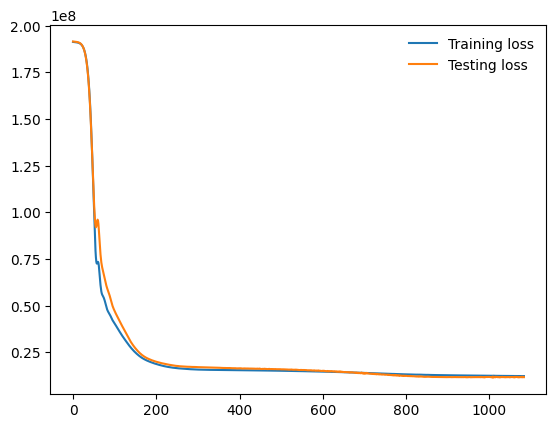

Эпоха 0 - train loss: 191326064.0, test loss: 191542784.0
Эпоха 100 - train loss: 39854724.0, test loss: 47319784.0
Эпоха 200 - train loss: 17133886.0, test loss: 18244072.0
Эпоха 300 - train loss: 15448739.0, test loss: 16576999.0
Эпоха 400 - train loss: 14971079.0, test loss: 16202197.0
Эпоха 500 - train loss: 13444806.0, test loss: 14329907.0
Эпоха 600 - train loss: 10946740.0, test loss: 10999897.0
Early stopping at epoch 699


Эпоха 0 - train loss: 191319728.0, test loss: 191509904.0
Эпоха 100 - train loss: 31322506.0, test loss: 34992288.0
Эпоха 200 - train loss: 15931806.0, test loss: 17855836.0
Эпоха 300 - train loss: 15541576.0, test loss: 17246670.0
Эпоха 400 - train loss: 15401987.0, test loss: 17322316.0
Early stopping at epoch 437


Эпоха 0 - train loss: 191164576.0, test loss: 191369344.0
Эпоха 100 - train loss: 36533744.0, test loss: 42014288.0
Эпоха 200 - train loss: 17792356.0, test loss: 19398390.0
Эпоха 300 - train loss: 15646394.0, test loss: 17494592.0
Эпоха 400 - train loss: 15469114.0, test loss: 17197392.0
Эпоха 500 - train loss: 15399025.0, test loss: 17009932.0
Эпоха 600 - train loss: 15331038.0, test loss: 16962340.0
Эпоха 700 - train loss: 15257144.0, test loss: 16802466.0
Эпоха 800 - train loss: 15168391.0, test loss: 16702989.0
Эпоха 900 - train loss: 15071414.0, test loss: 16483844.0
Эпоха 1000 - train loss: 14590656.0, test loss: 17275388.0
Early stopping at epoch 1017


Эпоха 0 - train loss: 191213216.0, test loss: 191425520.0
Эпоха 100 - train loss: 34995372.0, test loss: 40120720.0
Эпоха 200 - train loss: 16671583.0, test loss: 18010678.0
Эпоха 300 - train loss: 15546657.0, test loss: 17016538.0
Эпоха 400 - train loss: 15433721.0, test loss: 16830340.0
Эпоха 500 - train loss: 15355314.0, test loss: 16783172.0
Эпоха 600 - train loss: 15260911.0, test loss: 16567767.0
Эпоха 700 - train loss: 15147961.0, test loss: 16508222.0
Эпоха 800 - train loss: 15007081.0, test loss: 16357783.0
Эпоха 900 - train loss: 14852092.0, test loss: 16389141.0
Эпоха 1000 - train loss: 14667819.0, test loss: 16179936.0
Early stopping at epoch 1049


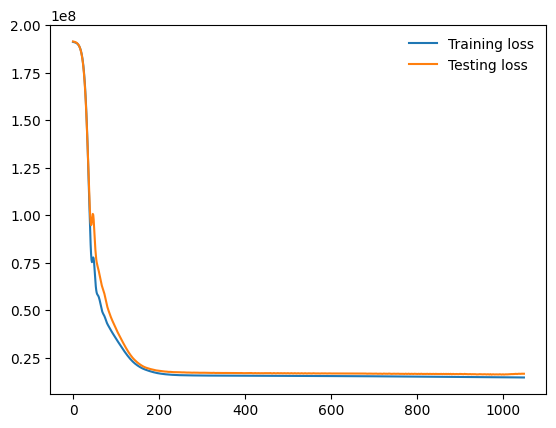

Эпоха 0 - train loss: 191344048.0, test loss: 191532624.0
Эпоха 100 - train loss: 31964996.0, test loss: 36106224.0
Эпоха 200 - train loss: 16049430.0, test loss: 17937578.0
Эпоха 300 - train loss: 15527827.0, test loss: 17114574.0
Эпоха 400 - train loss: 15308854.0, test loss: 16967294.0
Эпоха 500 - train loss: 15037765.0, test loss: 16735480.0
Эпоха 600 - train loss: 14696411.0, test loss: 16315247.0
Эпоха 700 - train loss: 14239599.0, test loss: 15961651.0
Эпоха 800 - train loss: 13735107.0, test loss: 15066991.0
Эпоха 900 - train loss: 13425576.0, test loss: 14653216.0
Эпоха 1000 - train loss: 13208537.0, test loss: 14038844.0
Эпоха 1100 - train loss: 13082948.0, test loss: 13954478.0
Early stopping at epoch 1160


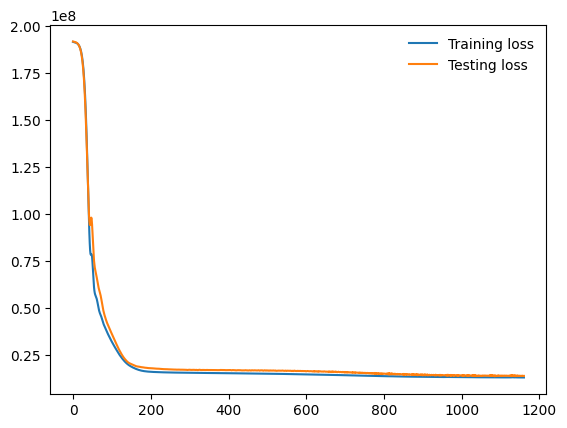

Эпоха 0 - train loss: 191284176.0, test loss: 191464416.0
Эпоха 100 - train loss: 37360496.0, test loss: 43559932.0
Эпоха 200 - train loss: 18109922.0, test loss: 19489456.0
Эпоха 300 - train loss: 15714108.0, test loss: 17487990.0
Эпоха 400 - train loss: 15496805.0, test loss: 17162616.0
Эпоха 500 - train loss: 15430601.0, test loss: 17168788.0
Early stopping at epoch 597


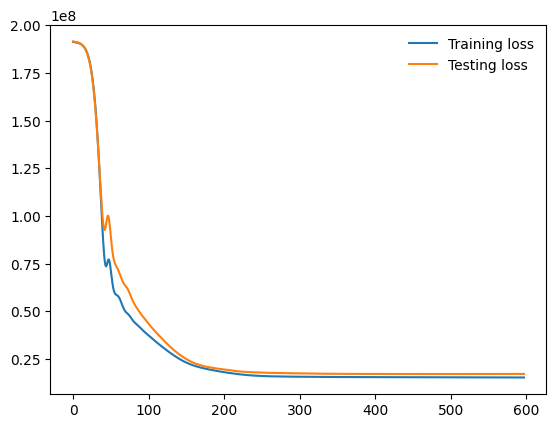

Эпоха 0 - train loss: 191228768.0, test loss: 191427408.0
Эпоха 100 - train loss: 29770800.0, test loss: 33272794.0
Эпоха 200 - train loss: 15642846.0, test loss: 17251410.0
Эпоха 300 - train loss: 15038117.0, test loss: 16513199.0
Эпоха 400 - train loss: 14511965.0, test loss: 16037000.0
Эпоха 500 - train loss: 13782121.0, test loss: 15191220.0
Эпоха 600 - train loss: 12803845.0, test loss: 13729077.0
Эпоха 700 - train loss: 11732090.0, test loss: 12728860.0
Эпоха 800 - train loss: 10289190.0, test loss: 13305822.0
Early stopping at epoch 836


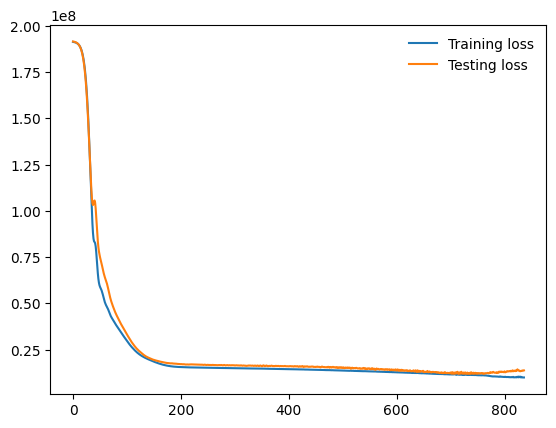

Эпоха 0 - train loss: 191306432.0, test loss: 191440912.0
Эпоха 100 - train loss: 29706796.0, test loss: 32973222.0
Эпоха 200 - train loss: 15834475.0, test loss: 17565756.0
Эпоха 300 - train loss: 15523117.0, test loss: 17097288.0
Эпоха 400 - train loss: 15393677.0, test loss: 17090782.0
Early stopping at epoch 486


Эпоха 0 - train loss: 191289520.0, test loss: 191501344.0
Эпоха 100 - train loss: 42269836.0, test loss: 50806292.0
Эпоха 200 - train loss: 20030754.0, test loss: 21223232.0
Эпоха 300 - train loss: 15861825.0, test loss: 17661916.0
Эпоха 400 - train loss: 15514120.0, test loss: 17094452.0
Эпоха 500 - train loss: 15368833.0, test loss: 16862674.0
Эпоха 600 - train loss: 15223401.0, test loss: 16639147.0
Эпоха 700 - train loss: 15026011.0, test loss: 16498743.0
Эпоха 800 - train loss: 14725283.0, test loss: 16018274.0
Эпоха 900 - train loss: 14063130.0, test loss: 15028088.0
Эпоха 1000 - train loss: 13325550.0, test loss: 14076651.0
Эпоха 1100 - train loss: 12818656.0, test loss: 13486268.0
Эпоха 1200 - train loss: 12520079.0, test loss: 13037395.0
Эпоха 1300 - train loss: 12328984.0, test loss: 12911695.0
Эпоха 1400 - train loss: 12195932.0, test loss: 12575976.0
Эпоха 1500 - train loss: 12126115.0, test loss: 12258466.0
Эпоха 1600 - train loss: 12040204.0, test loss: 11886127.0
Эпоха 1

Эпоха 0 - train loss: 191347504.0, test loss: 191544736.0
Эпоха 100 - train loss: 33604608.0, test loss: 38132704.0
Эпоха 200 - train loss: 16342510.0, test loss: 17827558.0
Эпоха 300 - train loss: 15600834.0, test loss: 16916226.0
Эпоха 400 - train loss: 15259930.0, test loss: 16582137.0
Эпоха 500 - train loss: 14749046.0, test loss: 16381742.0
Эпоха 600 - train loss: 13855988.0, test loss: 15865703.0
Эпоха 700 - train loss: 12732925.0, test loss: 14938285.0
Эпоха 800 - train loss: 11339086.0, test loss: 15099630.0
Эпоха 900 - train loss: 9793357.0, test loss: 15300311.0
Эпоха 1000 - train loss: 8818910.0, test loss: 14579597.0
Early stopping at epoch 1025


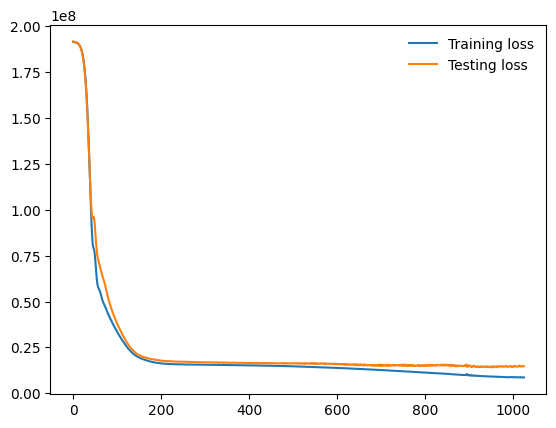

Эпоха 0 - train loss: 191409648.0, test loss: 191587344.0
Эпоха 100 - train loss: 31921826.0, test loss: 35412140.0
Эпоха 200 - train loss: 16562468.0, test loss: 18267758.0
Эпоха 300 - train loss: 15550591.0, test loss: 17437976.0
Эпоха 400 - train loss: 15389413.0, test loss: 17161664.0
Эпоха 500 - train loss: 14986780.0, test loss: 16702130.0
Эпоха 600 - train loss: 14422561.0, test loss: 16126884.0
Эпоха 700 - train loss: 14062771.0, test loss: 15829167.0
Эпоха 800 - train loss: 13651307.0, test loss: 15632929.0
Early stopping at epoch 800


Эпоха 0 - train loss: 191281952.0, test loss: 191463552.0
Эпоха 100 - train loss: 36350080.0, test loss: 42686608.0
Эпоха 200 - train loss: 16443579.0, test loss: 17622070.0
Эпоха 300 - train loss: 15453568.0, test loss: 16429717.0
Эпоха 400 - train loss: 15178391.0, test loss: 16288270.0
Early stopping at epoch 424


Эпоха 0 - train loss: 191379936.0, test loss: 191530832.0
Эпоха 100 - train loss: 30838640.0, test loss: 34847572.0
Эпоха 200 - train loss: 15790167.0, test loss: 17275272.0
Эпоха 300 - train loss: 15513342.0, test loss: 16903722.0
Эпоха 400 - train loss: 15368580.0, test loss: 16513761.0
Early stopping at epoch 470


Эпоха 0 - train loss: 191281872.0, test loss: 191432640.0
Эпоха 100 - train loss: 28562258.0, test loss: 31484402.0
Эпоха 200 - train loss: 15637604.0, test loss: 17328870.0
Эпоха 300 - train loss: 15046432.0, test loss: 16543864.0
Эпоха 400 - train loss: 14485727.0, test loss: 15849926.0
Эпоха 500 - train loss: 13672554.0, test loss: 15426376.0
Эпоха 600 - train loss: 12558149.0, test loss: 14563973.0
Эпоха 700 - train loss: 11428883.0, test loss: 12984530.0
Эпоха 800 - train loss: 10729692.0, test loss: 12730773.0
Эпоха 900 - train loss: 10309972.0, test loss: 12041732.0
Эпоха 1000 - train loss: 10287807.0, test loss: 11685684.0
Early stopping at epoch 1073


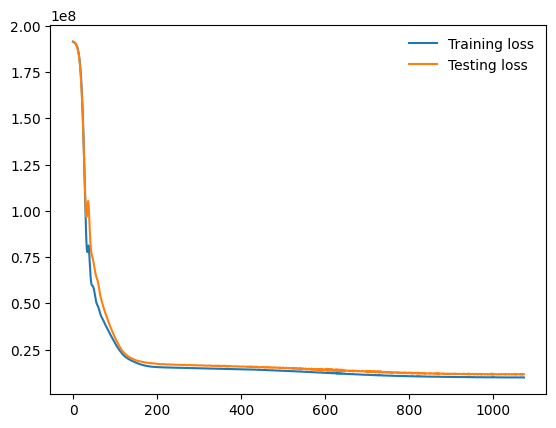

Эпоха 0 - train loss: 191397088.0, test loss: 191509792.0
Эпоха 100 - train loss: 36946876.0, test loss: 42427728.0
Эпоха 200 - train loss: 16861718.0, test loss: 18302574.0
Эпоха 300 - train loss: 15510644.0, test loss: 17448974.0
Эпоха 400 - train loss: 15334094.0, test loss: 17393870.0
Эпоха 500 - train loss: 15079179.0, test loss: 17200186.0
Эпоха 600 - train loss: 14641912.0, test loss: 16710931.0
Эпоха 700 - train loss: 13989226.0, test loss: 15790674.0
Эпоха 800 - train loss: 12918143.0, test loss: 14617794.0
Эпоха 900 - train loss: 10997670.0, test loss: 13549055.0
Эпоха 1000 - train loss: 9759226.0, test loss: 12810054.0
Эпоха 1100 - train loss: 9483936.0, test loss: 12920264.0
Early stopping at epoch 1166


Эпоха 0 - train loss: 191290816.0, test loss: 191446752.0
Эпоха 100 - train loss: 26480874.0, test loss: 28740770.0
Эпоха 200 - train loss: 15687972.0, test loss: 17168646.0
Эпоха 300 - train loss: 15460386.0, test loss: 16772860.0
Эпоха 400 - train loss: 15332447.0, test loss: 16871468.0
Early stopping at epoch 401


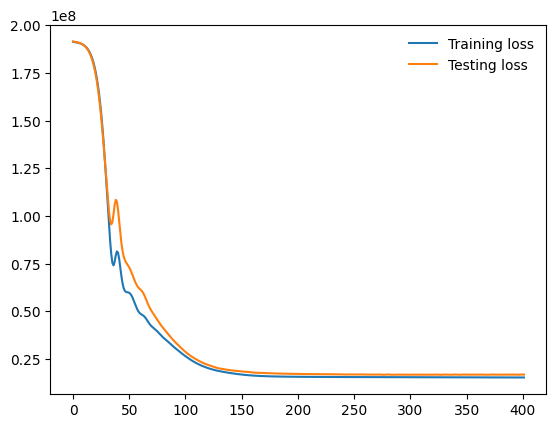

Эпоха 0 - train loss: 191274736.0, test loss: 191473216.0
Эпоха 100 - train loss: 29480344.0, test loss: 32645160.0
Эпоха 200 - train loss: 15871976.0, test loss: 17125698.0
Эпоха 300 - train loss: 15557295.0, test loss: 16820944.0
Эпоха 400 - train loss: 15463620.0, test loss: 16676969.0
Эпоха 500 - train loss: 15292246.0, test loss: 16704966.0
Эпоха 600 - train loss: 14834577.0, test loss: 16197977.0
Эпоха 700 - train loss: 13863201.0, test loss: 15387228.0
Эпоха 800 - train loss: 12792052.0, test loss: 14153925.0
Early stopping at epoch 888


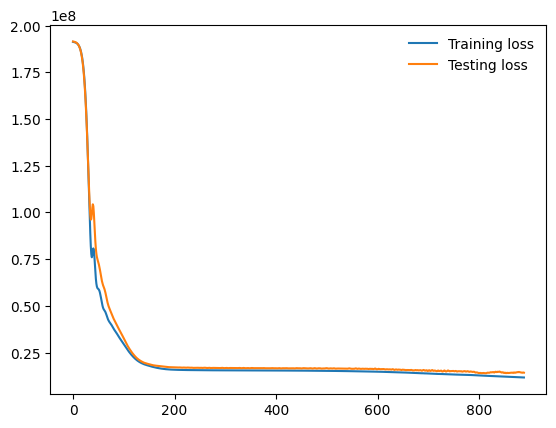

Эпоха 0 - train loss: 191218768.0, test loss: 191417968.0
Эпоха 100 - train loss: 35919540.0, test loss: 41163632.0
Эпоха 200 - train loss: 17179724.0, test loss: 18574798.0
Эпоха 300 - train loss: 15570973.0, test loss: 17122744.0
Эпоха 400 - train loss: 15408786.0, test loss: 16714356.0
Эпоха 500 - train loss: 15304714.0, test loss: 16635650.0
Эпоха 600 - train loss: 15181752.0, test loss: 16370957.0
Early stopping at epoch 674


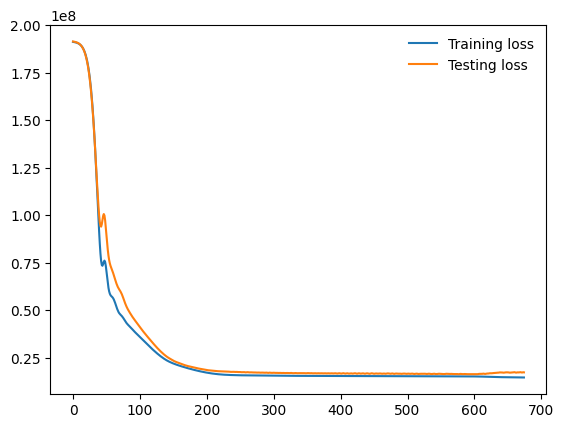

Эпоха 0 - train loss: 191155376.0, test loss: 191337136.0
Эпоха 100 - train loss: 32309108.0, test loss: 36738400.0
Эпоха 200 - train loss: 16657695.0, test loss: 17866396.0
Эпоха 300 - train loss: 15627340.0, test loss: 16808430.0
Эпоха 400 - train loss: 15374801.0, test loss: 16536071.0
Early stopping at epoch 475


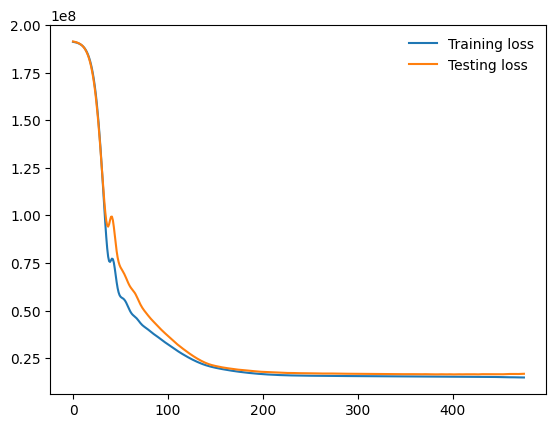

Эпоха 0 - train loss: 191310624.0, test loss: 191506848.0
Эпоха 100 - train loss: 33675720.0, test loss: 37707504.0
Эпоха 200 - train loss: 16037421.0, test loss: 17043454.0
Эпоха 300 - train loss: 15515131.0, test loss: 16406024.0
Эпоха 400 - train loss: 15365110.0, test loss: 16278421.0
Эпоха 500 - train loss: 15206156.0, test loss: 16075886.0
Эпоха 600 - train loss: 14932451.0, test loss: 15754707.0
Эпоха 700 - train loss: 14539401.0, test loss: 15247172.0
Эпоха 800 - train loss: 13921110.0, test loss: 14528442.0
Эпоха 900 - train loss: 12913683.0, test loss: 13622584.0
Эпоха 1000 - train loss: 11226700.0, test loss: 12718427.0
Эпоха 1100 - train loss: 9789763.0, test loss: 12856782.0
Early stopping at epoch 1156


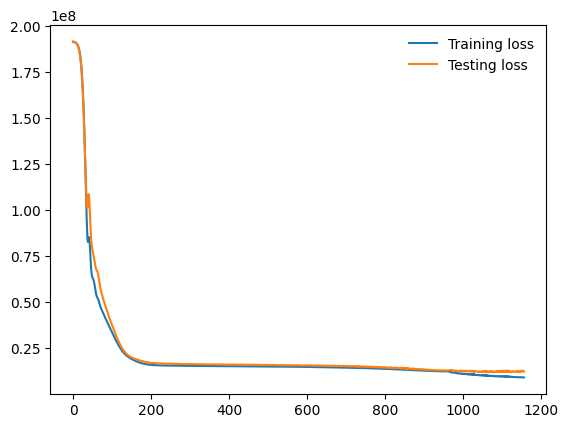

Эпоха 0 - train loss: 191273904.0, test loss: 191463136.0
Эпоха 100 - train loss: 31768776.0, test loss: 35771280.0
Эпоха 200 - train loss: 16519656.0, test loss: 17587032.0
Эпоха 300 - train loss: 15491302.0, test loss: 16678086.0
Эпоха 400 - train loss: 15330703.0, test loss: 16479537.0
Эпоха 500 - train loss: 15161629.0, test loss: 16417812.0
Эпоха 600 - train loss: 14872718.0, test loss: 16112254.0
Эпоха 700 - train loss: 14145271.0, test loss: 16129390.0
Эпоха 800 - train loss: 12932190.0, test loss: 15382238.0
Early stopping at epoch 889


Эпоха 0 - train loss: 191340608.0, test loss: 191510000.0
Эпоха 100 - train loss: 32509862.0, test loss: 36581308.0
Эпоха 200 - train loss: 16247892.0, test loss: 17109254.0
Эпоха 300 - train loss: 15477549.0, test loss: 16342906.0
Эпоха 400 - train loss: 15273841.0, test loss: 16340339.0
Early stopping at epoch 412


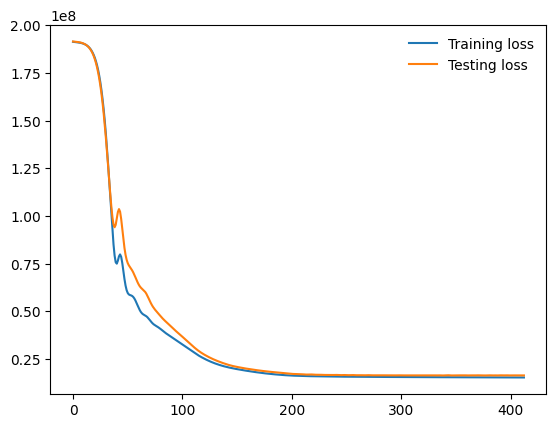

Эпоха 0 - train loss: 191292832.0, test loss: 191452480.0
Эпоха 100 - train loss: 28593516.0, test loss: 32286346.0
Эпоха 200 - train loss: 16038141.0, test loss: 17856778.0
Эпоха 300 - train loss: 15462707.0, test loss: 16907882.0
Эпоха 400 - train loss: 15343829.0, test loss: 16633476.0
Эпоха 500 - train loss: 15173229.0, test loss: 16693191.0
Early stopping at epoch 524


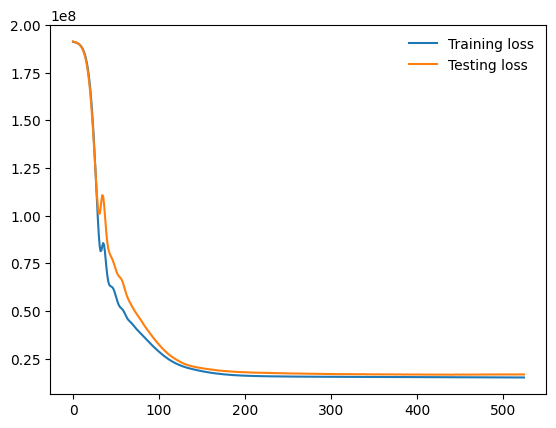

Эпоха 0 - train loss: 191259856.0, test loss: 191386288.0
Эпоха 100 - train loss: 29850554.0, test loss: 33855548.0
Эпоха 200 - train loss: 15865234.0, test loss: 17770086.0
Эпоха 300 - train loss: 15438449.0, test loss: 17146092.0
Эпоха 400 - train loss: 15253315.0, test loss: 16775253.0
Эпоха 500 - train loss: 15079021.0, test loss: 16666724.0
Эпоха 600 - train loss: 14844841.0, test loss: 16275499.0
Эпоха 700 - train loss: 14468401.0, test loss: 15895859.0
Эпоха 800 - train loss: 13430696.0, test loss: 14344395.0
Эпоха 900 - train loss: 12690312.0, test loss: 13085541.0
Эпоха 1000 - train loss: 12112798.0, test loss: 12213954.0
Эпоха 1100 - train loss: 11716452.0, test loss: 11539566.0
Эпоха 1200 - train loss: 11457504.0, test loss: 10950565.0
Эпоха 1300 - train loss: 11046524.0, test loss: 10507916.0
Эпоха 1400 - train loss: 9794244.0, test loss: 9881615.0
Early stopping at epoch 1465


Эпоха 0 - train loss: 191216608.0, test loss: 191365456.0
Эпоха 100 - train loss: 26067866.0, test loss: 28368840.0
Эпоха 200 - train loss: 15727348.0, test loss: 17381870.0
Эпоха 300 - train loss: 15488739.0, test loss: 17198256.0
Early stopping at epoch 335


Эпоха 0 - train loss: 191407648.0, test loss: 191496480.0
Эпоха 100 - train loss: 29053424.0, test loss: 32299818.0
Эпоха 200 - train loss: 15685209.0, test loss: 17796764.0
Эпоха 300 - train loss: 15309381.0, test loss: 17127928.0
Эпоха 400 - train loss: 15009101.0, test loss: 16841422.0
Эпоха 500 - train loss: 14359463.0, test loss: 16384424.0
Эпоха 600 - train loss: 13605042.0, test loss: 15244742.0
Эпоха 700 - train loss: 12794541.0, test loss: 15057189.0
Early stopping at epoch 784


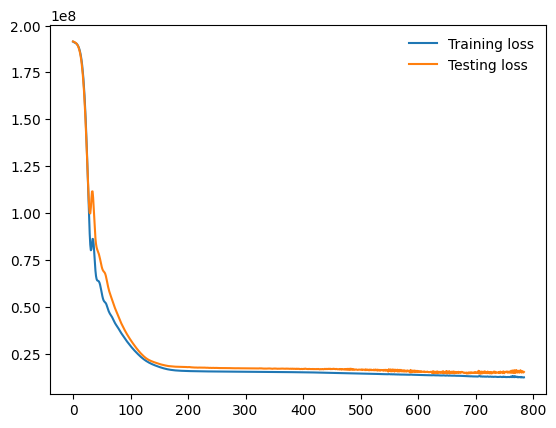

Эпоха 0 - train loss: 191347008.0, test loss: 191559776.0
Эпоха 100 - train loss: 41636212.0, test loss: 49092448.0
Эпоха 200 - train loss: 18754792.0, test loss: 19972238.0
Эпоха 300 - train loss: 15738935.0, test loss: 17290544.0
Эпоха 400 - train loss: 15416482.0, test loss: 16791794.0
Эпоха 500 - train loss: 15311437.0, test loss: 16655042.0
Эпоха 600 - train loss: 15161834.0, test loss: 16586329.0
Эпоха 700 - train loss: 14694024.0, test loss: 15914029.0
Эпоха 800 - train loss: 14057017.0, test loss: 15098074.0
Эпоха 900 - train loss: 13225920.0, test loss: 14389975.0
Эпоха 1000 - train loss: 12381892.0, test loss: 13029766.0
Эпоха 1100 - train loss: 11910945.0, test loss: 12487308.0
Эпоха 1200 - train loss: 11663719.0, test loss: 12317135.0
Early stopping at epoch 1267


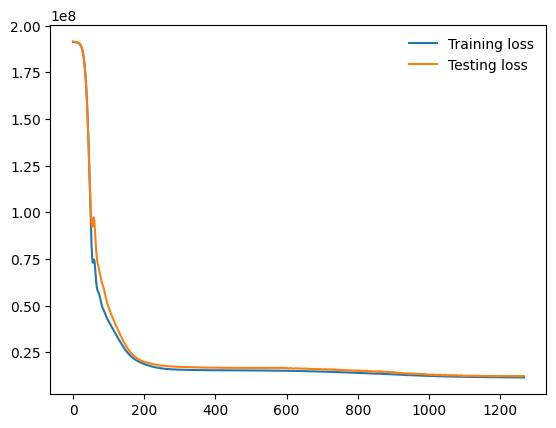

Эпоха 0 - train loss: 191358352.0, test loss: 191554896.0
Эпоха 100 - train loss: 38318116.0, test loss: 44371092.0
Эпоха 200 - train loss: 18671758.0, test loss: 19719620.0
Эпоха 300 - train loss: 15737786.0, test loss: 16916308.0
Эпоха 400 - train loss: 15490411.0, test loss: 16607150.0
Эпоха 500 - train loss: 15350400.0, test loss: 16495929.0
Эпоха 600 - train loss: 15203456.0, test loss: 16424006.0
Эпоха 700 - train loss: 15049966.0, test loss: 16289147.0
Эпоха 800 - train loss: 14864056.0, test loss: 16109195.0
Эпоха 900 - train loss: 14589991.0, test loss: 16009286.0
Early stopping at epoch 917


Эпоха 0 - train loss: 191348688.0, test loss: 191559584.0
Эпоха 100 - train loss: 34156640.0, test loss: 38758004.0
Эпоха 200 - train loss: 16325775.0, test loss: 17943752.0
Эпоха 300 - train loss: 15462043.0, test loss: 16833156.0
Эпоха 400 - train loss: 15289691.0, test loss: 16632034.0
Эпоха 500 - train loss: 15143293.0, test loss: 16548201.0
Эпоха 600 - train loss: 14991060.0, test loss: 16460023.0
Эпоха 700 - train loss: 14809948.0, test loss: 16294367.0
Эпоха 800 - train loss: 14568009.0, test loss: 16260813.0
Early stopping at epoch 835


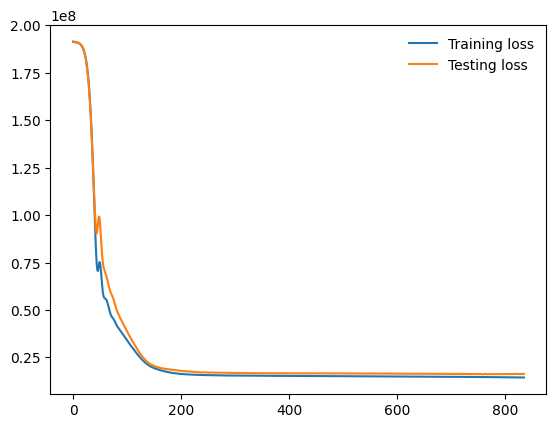

Эпоха 0 - train loss: 191231808.0, test loss: 191438672.0
Эпоха 100 - train loss: 37142564.0, test loss: 42668688.0
Эпоха 200 - train loss: 17224614.0, test loss: 18639680.0
Эпоха 300 - train loss: 15595316.0, test loss: 17320754.0
Эпоха 400 - train loss: 15352776.0, test loss: 16857284.0
Эпоха 500 - train loss: 15158336.0, test loss: 16586446.0
Эпоха 600 - train loss: 14874066.0, test loss: 16251942.0
Эпоха 700 - train loss: 14539794.0, test loss: 15798537.0
Early stopping at epoch 793


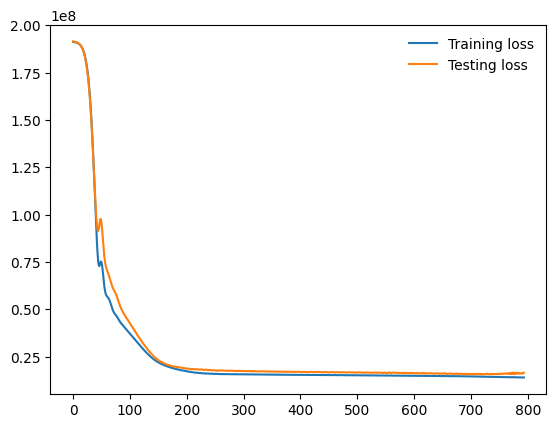

Эпоха 0 - train loss: 191215472.0, test loss: 191385568.0
Эпоха 100 - train loss: 32806326.0, test loss: 36869000.0
Эпоха 200 - train loss: 16030605.0, test loss: 17713618.0
Эпоха 300 - train loss: 15395158.0, test loss: 16853692.0
Эпоха 400 - train loss: 15224993.0, test loss: 16793344.0
Early stopping at epoch 482


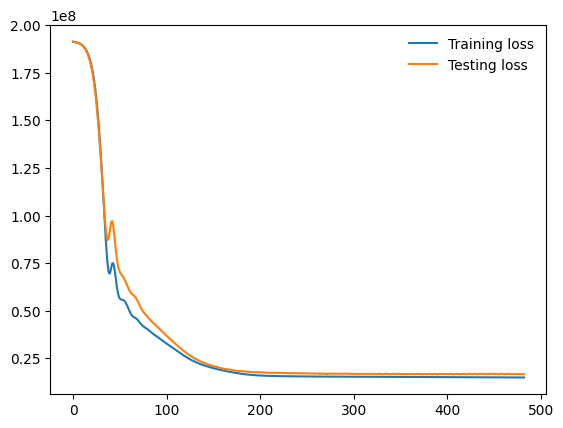

Эпоха 0 - train loss: 191310064.0, test loss: 191485456.0
Эпоха 100 - train loss: 30951838.0, test loss: 34516760.0
Эпоха 200 - train loss: 15758913.0, test loss: 17510570.0
Эпоха 300 - train loss: 15317105.0, test loss: 16946998.0
Эпоха 400 - train loss: 14737849.0, test loss: 16611029.0
Эпоха 500 - train loss: 13843737.0, test loss: 15051454.0
Эпоха 600 - train loss: 13239516.0, test loss: 13934732.0
Эпоха 700 - train loss: 12738381.0, test loss: 12789064.0
Эпоха 800 - train loss: 12384138.0, test loss: 12209127.0
Эпоха 900 - train loss: 12197679.0, test loss: 11593111.0
Эпоха 1000 - train loss: 12052876.0, test loss: 11211973.0
Эпоха 1100 - train loss: 11926741.0, test loss: 10931785.0
Эпоха 1200 - train loss: 11816363.0, test loss: 10892433.0
Эпоха 1300 - train loss: 11702332.0, test loss: 10644831.0
Эпоха 1400 - train loss: 11665689.0, test loss: 10590350.0
Эпоха 1500 - train loss: 11544968.0, test loss: 10404965.0
Эпоха 1600 - train loss: 11459974.0, test loss: 10354679.0
Эпоха 1

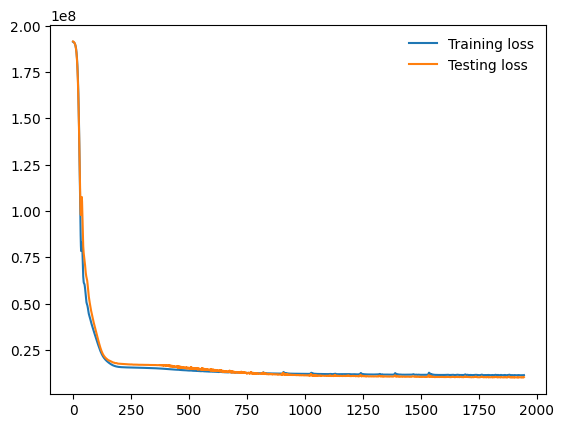

Эпоха 0 - train loss: 191205424.0, test loss: 191398496.0
Эпоха 100 - train loss: 29677818.0, test loss: 33238670.0
Эпоха 200 - train loss: 15995145.0, test loss: 17547124.0
Эпоха 300 - train loss: 15419011.0, test loss: 16857130.0
Эпоха 400 - train loss: 14968059.0, test loss: 16519422.0
Эпоха 500 - train loss: 13957934.0, test loss: 15773714.0
Эпоха 600 - train loss: 12974262.0, test loss: 14686810.0
Эпоха 700 - train loss: 11928391.0, test loss: 13521141.0
Эпоха 800 - train loss: 10134389.0, test loss: 12314406.0
Early stopping at epoch 887


Эпоха 0 - train loss: 191289232.0, test loss: 191459344.0
Эпоха 100 - train loss: 33603924.0, test loss: 38046544.0
Эпоха 200 - train loss: 16049590.0, test loss: 17572298.0
Эпоха 300 - train loss: 15479483.0, test loss: 16902782.0
Эпоха 400 - train loss: 15288683.0, test loss: 16723655.0
Эпоха 500 - train loss: 15064989.0, test loss: 16518184.0
Эпоха 600 - train loss: 14743930.0, test loss: 16380282.0
Эпоха 700 - train loss: 14234617.0, test loss: 16093751.0
Эпоха 800 - train loss: 13830628.0, test loss: 15138184.0
Эпоха 900 - train loss: 13496129.0, test loss: 14405384.0
Early stopping at epoch 932


Эпоха 0 - train loss: 191317664.0, test loss: 191453904.0
Эпоха 100 - train loss: 27434518.0, test loss: 30590474.0
Эпоха 200 - train loss: 15708933.0, test loss: 17473542.0
Эпоха 300 - train loss: 15292995.0, test loss: 16879016.0
Эпоха 400 - train loss: 14869315.0, test loss: 16471767.0
Эпоха 500 - train loss: 13955407.0, test loss: 15426195.0
Эпоха 600 - train loss: 12967989.0, test loss: 13956712.0
Эпоха 700 - train loss: 12287656.0, test loss: 14821698.0
Early stopping at epoch 709


Эпоха 0 - train loss: 191317136.0, test loss: 191494320.0
Эпоха 100 - train loss: 31863644.0, test loss: 36278808.0
Эпоха 200 - train loss: 16340001.0, test loss: 17947930.0
Эпоха 300 - train loss: 15553822.0, test loss: 16857354.0
Эпоха 400 - train loss: 15391584.0, test loss: 16540172.0
Эпоха 500 - train loss: 15216765.0, test loss: 16357417.0
Эпоха 600 - train loss: 15035956.0, test loss: 16142822.0
Эпоха 700 - train loss: 14816479.0, test loss: 15959223.0
Эпоха 800 - train loss: 14527591.0, test loss: 15735616.0
Эпоха 900 - train loss: 14139698.0, test loss: 15675289.0
Эпоха 1000 - train loss: 13844590.0, test loss: 15551995.0
Эпоха 1100 - train loss: 13653174.0, test loss: 15181961.0
Эпоха 1200 - train loss: 13301212.0, test loss: 14388216.0
Early stopping at epoch 1203


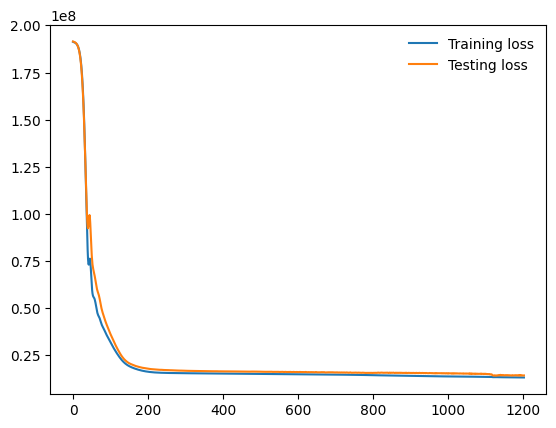

Эпоха 0 - train loss: 191295280.0, test loss: 191513312.0
Эпоха 100 - train loss: 32224134.0, test loss: 36567508.0
Эпоха 200 - train loss: 16497363.0, test loss: 17921720.0
Эпоха 300 - train loss: 15468115.0, test loss: 17007422.0
Эпоха 400 - train loss: 15297901.0, test loss: 16831520.0
Эпоха 500 - train loss: 15110006.0, test loss: 16690476.0
Early stopping at epoch 583


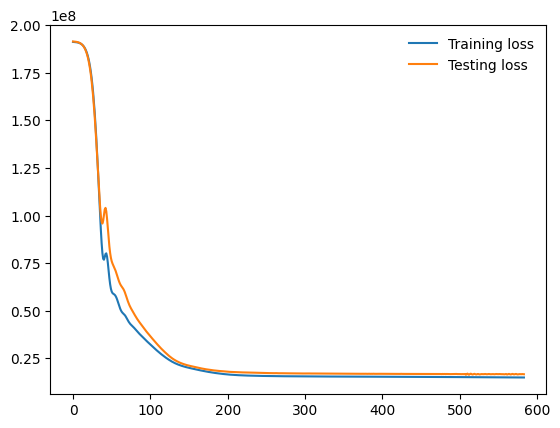

Эпоха 0 - train loss: 191310112.0, test loss: 191504816.0
Эпоха 100 - train loss: 31556294.0, test loss: 35252964.0
Эпоха 200 - train loss: 16280046.0, test loss: 17920074.0
Эпоха 300 - train loss: 15427308.0, test loss: 17245154.0
Эпоха 400 - train loss: 15059789.0, test loss: 16930868.0
Эпоха 500 - train loss: 14526730.0, test loss: 16495493.0
Эпоха 600 - train loss: 13754372.0, test loss: 15833916.0
Эпоха 700 - train loss: 12744454.0, test loss: 14656288.0
Эпоха 800 - train loss: 11704216.0, test loss: 13630010.0
Эпоха 900 - train loss: 10963316.0, test loss: 13765336.0
Эпоха 1000 - train loss: 9985914.0, test loss: 12648338.0
Early stopping at epoch 1043


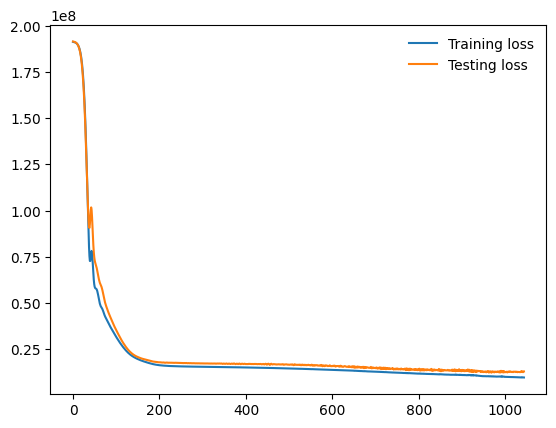

Эпоха 0 - train loss: 191286992.0, test loss: 191487968.0
Эпоха 100 - train loss: 29913086.0, test loss: 33223272.0
Эпоха 200 - train loss: 16408508.0, test loss: 17660904.0
Эпоха 300 - train loss: 15478953.0, test loss: 16944452.0
Эпоха 400 - train loss: 15286557.0, test loss: 16751162.0
Эпоха 500 - train loss: 14994250.0, test loss: 16340885.0
Эпоха 600 - train loss: 14511813.0, test loss: 15295810.0
Эпоха 700 - train loss: 14039657.0, test loss: 14907963.0
Эпоха 800 - train loss: 13548381.0, test loss: 14246696.0
Эпоха 900 - train loss: 13112111.0, test loss: 13253288.0
Эпоха 1000 - train loss: 12931495.0, test loss: 12969897.0
Эпоха 1100 - train loss: 12820631.0, test loss: 12893660.0
Early stopping at epoch 1197


Эпоха 0 - train loss: 191288400.0, test loss: 191455664.0
Эпоха 100 - train loss: 27915834.0, test loss: 30478298.0
Эпоха 200 - train loss: 16018682.0, test loss: 17450060.0
Эпоха 300 - train loss: 15525707.0, test loss: 16999672.0
Early stopping at epoch 364


Эпоха 0 - train loss: 191264736.0, test loss: 191457472.0
Эпоха 100 - train loss: 25139014.0, test loss: 27289720.0
Эпоха 200 - train loss: 15687291.0, test loss: 16928628.0
Эпоха 300 - train loss: 15269589.0, test loss: 16681703.0
Эпоха 400 - train loss: 14930158.0, test loss: 16618697.0
Эпоха 500 - train loss: 14490294.0, test loss: 16314831.0
Эпоха 600 - train loss: 14034143.0, test loss: 15839937.0
Эпоха 700 - train loss: 13615959.0, test loss: 15269742.0
Эпоха 800 - train loss: 13323782.0, test loss: 14517380.0
Эпоха 900 - train loss: 12924840.0, test loss: 13711940.0
Эпоха 1000 - train loss: 12727806.0, test loss: 13162286.0
Эпоха 1100 - train loss: 12558863.0, test loss: 13093152.0
Эпоха 1200 - train loss: 12306555.0, test loss: 13018491.0
Early stopping at epoch 1281


Эпоха 0 - train loss: 191317536.0, test loss: 191494128.0
Эпоха 100 - train loss: 26100728.0, test loss: 28711140.0
Эпоха 200 - train loss: 15831213.0, test loss: 17617802.0
Эпоха 300 - train loss: 15400269.0, test loss: 17120842.0
Эпоха 400 - train loss: 15245820.0, test loss: 16985542.0
Early stopping at epoch 489


Эпоха 0 - train loss: 191281696.0, test loss: 191427392.0
Эпоха 100 - train loss: 22704446.0, test loss: 24348386.0
Эпоха 200 - train loss: 15620389.0, test loss: 17254236.0
Эпоха 300 - train loss: 15335716.0, test loss: 16946776.0
Эпоха 400 - train loss: 15130830.0, test loss: 16627085.0
Эпоха 500 - train loss: 14748685.0, test loss: 16095480.0
Эпоха 600 - train loss: 14221044.0, test loss: 15428141.0
Эпоха 700 - train loss: 13353873.0, test loss: 14013624.0
Эпоха 800 - train loss: 11635886.0, test loss: 12189760.0
Эпоха 900 - train loss: 9470772.0, test loss: 11434014.0
Эпоха 1000 - train loss: 8782559.0, test loss: 11729595.0
Early stopping at epoch 1013


Эпоха 0 - train loss: 191266976.0, test loss: 191389904.0
Эпоха 100 - train loss: 25275412.0, test loss: 27521424.0
Эпоха 200 - train loss: 15707334.0, test loss: 17179078.0
Эпоха 300 - train loss: 15363205.0, test loss: 16548475.0
Эпоха 400 - train loss: 14996177.0, test loss: 16286604.0
Эпоха 500 - train loss: 13944562.0, test loss: 15699378.0
Эпоха 600 - train loss: 12511960.0, test loss: 15293992.0
Early stopping at epoch 640


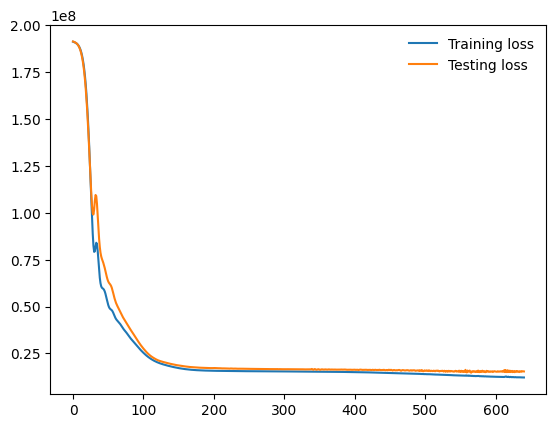

Эпоха 0 - train loss: 191318000.0, test loss: 191538832.0
Эпоха 100 - train loss: 36072432.0, test loss: 41306976.0
Эпоха 200 - train loss: 17909156.0, test loss: 19137378.0
Эпоха 300 - train loss: 15738254.0, test loss: 17403680.0
Эпоха 400 - train loss: 15533063.0, test loss: 17134502.0
Эпоха 500 - train loss: 15449031.0, test loss: 17067888.0
Эпоха 600 - train loss: 15348258.0, test loss: 17197624.0
Early stopping at epoch 605


Эпоха 0 - train loss: 191311360.0, test loss: 191458816.0
Эпоха 100 - train loss: 27788772.0, test loss: 30536668.0
Эпоха 200 - train loss: 15959539.0, test loss: 17652280.0
Эпоха 300 - train loss: 15443412.0, test loss: 16824582.0
Эпоха 400 - train loss: 15247457.0, test loss: 16613681.0
Эпоха 500 - train loss: 14978052.0, test loss: 16315470.0
Эпоха 600 - train loss: 14633843.0, test loss: 15787045.0
Эпоха 700 - train loss: 14162475.0, test loss: 15497587.0
Early stopping at epoch 733


Эпоха 0 - train loss: 191280288.0, test loss: 191458912.0
Эпоха 100 - train loss: 27444334.0, test loss: 29863664.0
Эпоха 200 - train loss: 15977903.0, test loss: 17856650.0
Эпоха 300 - train loss: 15393402.0, test loss: 17238658.0
Эпоха 400 - train loss: 15217939.0, test loss: 17172554.0
Эпоха 500 - train loss: 15028269.0, test loss: 17161664.0
Early stopping at epoch 501


Эпоха 0 - train loss: 191323008.0, test loss: 191520560.0
Эпоха 100 - train loss: 33020800.0, test loss: 37240760.0
Эпоха 200 - train loss: 17002068.0, test loss: 18279788.0
Эпоха 300 - train loss: 15594712.0, test loss: 17116508.0
Эпоха 400 - train loss: 15443639.0, test loss: 16856930.0
Эпоха 500 - train loss: 15341898.0, test loss: 16691319.0
Эпоха 600 - train loss: 15140730.0, test loss: 16748416.0
Early stopping at epoch 620


Эпоха 0 - train loss: 191367280.0, test loss: 191550224.0
Эпоха 100 - train loss: 28017676.0, test loss: 31342758.0
Эпоха 200 - train loss: 15746665.0, test loss: 17409576.0
Эпоха 300 - train loss: 15340348.0, test loss: 16829940.0
Эпоха 400 - train loss: 15180359.0, test loss: 16781182.0
Эпоха 500 - train loss: 14973749.0, test loss: 16672498.0
Эпоха 600 - train loss: 14619113.0, test loss: 16500543.0
Early stopping at epoch 634


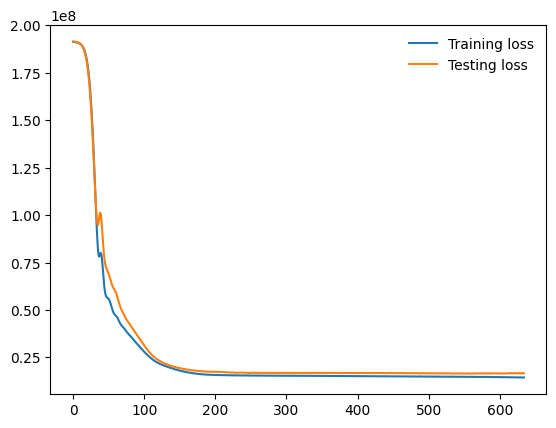

Эпоха 0 - train loss: 191333792.0, test loss: 191498528.0
Эпоха 100 - train loss: 25080234.0, test loss: 27610526.0
Эпоха 200 - train loss: 15775645.0, test loss: 17584404.0
Эпоха 300 - train loss: 15456034.0, test loss: 17053630.0
Эпоха 400 - train loss: 15288411.0, test loss: 16850518.0
Эпоха 500 - train loss: 15064835.0, test loss: 16821694.0
Эпоха 600 - train loss: 14742139.0, test loss: 16543012.0
Эпоха 700 - train loss: 14134468.0, test loss: 15601673.0
Эпоха 800 - train loss: 13210188.0, test loss: 14202484.0
Эпоха 900 - train loss: 11988241.0, test loss: 13761504.0
Early stopping at epoch 955


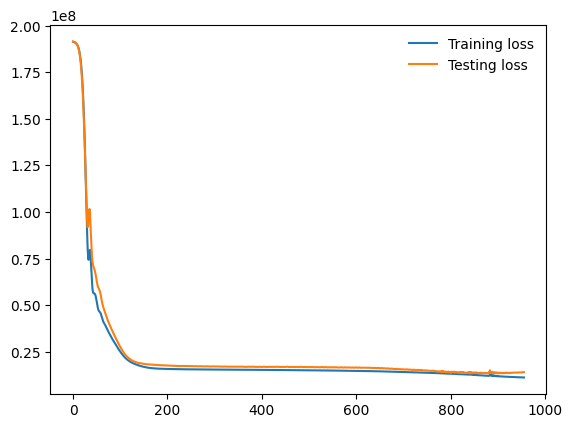

Эпоха 0 - train loss: 191287296.0, test loss: 191464896.0
Эпоха 100 - train loss: 25998904.0, test loss: 28007560.0
Эпоха 200 - train loss: 15530061.0, test loss: 17007132.0
Эпоха 300 - train loss: 15252133.0, test loss: 16667929.0
Эпоха 400 - train loss: 15007255.0, test loss: 16450956.0
Эпоха 500 - train loss: 14543669.0, test loss: 16294885.0
Эпоха 600 - train loss: 14092824.0, test loss: 15655105.0
Эпоха 700 - train loss: 13729929.0, test loss: 15091686.0
Эпоха 800 - train loss: 13381843.0, test loss: 14022609.0
Эпоха 900 - train loss: 13103369.0, test loss: 13882873.0
Эпоха 1000 - train loss: 12698470.0, test loss: 13107922.0
Эпоха 1100 - train loss: 12404222.0, test loss: 12543791.0
Эпоха 1200 - train loss: 12158229.0, test loss: 12018095.0
Эпоха 1300 - train loss: 11503057.0, test loss: 11810669.0
Эпоха 1400 - train loss: 10435507.0, test loss: 11553577.0
Early stopping at epoch 1443


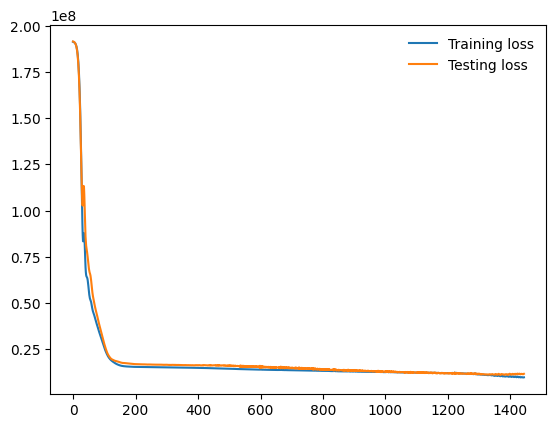

Эпоха 0 - train loss: 191199504.0, test loss: 191306064.0
Эпоха 100 - train loss: 23901618.0, test loss: 25616732.0
Эпоха 200 - train loss: 15526763.0, test loss: 17071720.0
Эпоха 300 - train loss: 15225291.0, test loss: 16705499.0
Эпоха 400 - train loss: 14983306.0, test loss: 16491714.0
Эпоха 500 - train loss: 14533743.0, test loss: 16369000.0
Эпоха 600 - train loss: 13867665.0, test loss: 15854543.0
Эпоха 700 - train loss: 13263773.0, test loss: 15464206.0
Эпоха 800 - train loss: 12664428.0, test loss: 13835515.0
Эпоха 900 - train loss: 12200927.0, test loss: 12544488.0
Эпоха 1000 - train loss: 12163406.0, test loss: 12640831.0
Early stopping at epoch 1079


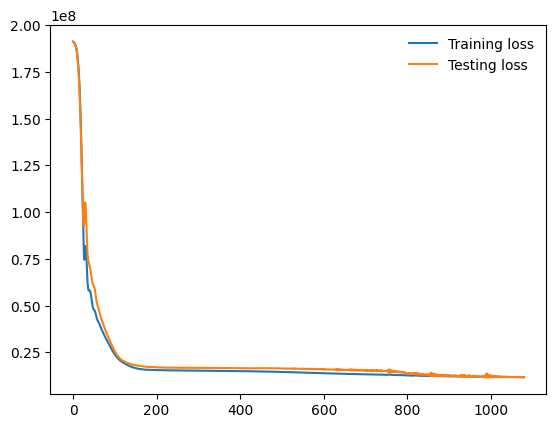

Эпоха 0 - train loss: 191252096.0, test loss: 191386256.0
Эпоха 100 - train loss: 26730950.0, test loss: 29458312.0
Эпоха 200 - train loss: 15629655.0, test loss: 16982564.0
Эпоха 300 - train loss: 15167851.0, test loss: 16338746.0
Эпоха 400 - train loss: 14653095.0, test loss: 16474713.0
Early stopping at epoch 419


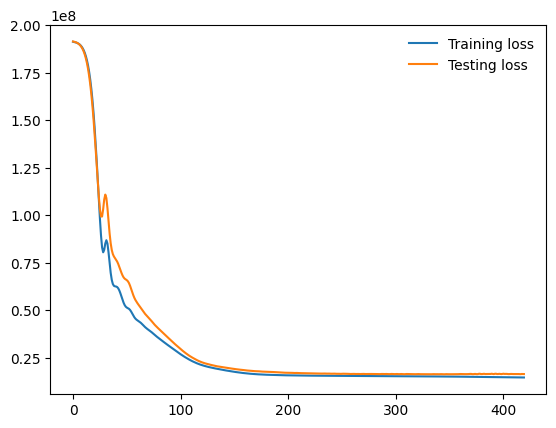

Эпоха 0 - train loss: 191218000.0, test loss: 191427168.0
Эпоха 100 - train loss: 37839756.0, test loss: 43799344.0
Эпоха 200 - train loss: 17828626.0, test loss: 18992286.0
Эпоха 300 - train loss: 15592142.0, test loss: 16991282.0
Эпоха 400 - train loss: 15371803.0, test loss: 16764593.0
Эпоха 500 - train loss: 15274417.0, test loss: 16716757.0
Эпоха 600 - train loss: 15196442.0, test loss: 16662216.0
Эпоха 700 - train loss: 15109384.0, test loss: 16650974.0
Эпоха 800 - train loss: 15013329.0, test loss: 16564120.0
Эпоха 900 - train loss: 14903100.0, test loss: 16494027.0
Эпоха 1000 - train loss: 14777603.0, test loss: 16417335.0
Эпоха 1100 - train loss: 14273059.0, test loss: 16122266.0
Эпоха 1200 - train loss: 13194261.0, test loss: 14264302.0
Эпоха 1300 - train loss: 11887842.0, test loss: 11594899.0
Эпоха 1400 - train loss: 10648659.0, test loss: 11017196.0
Early stopping at epoch 1480


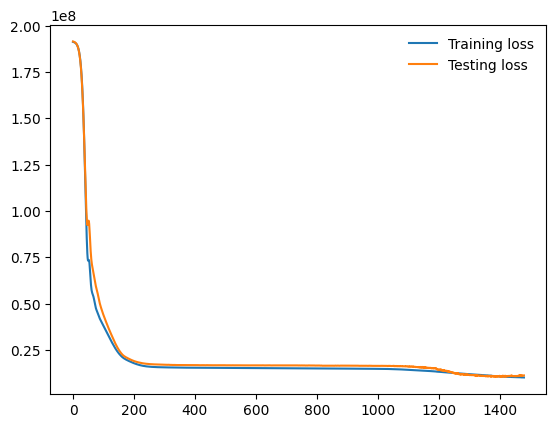

Эпоха 0 - train loss: 191211088.0, test loss: 191411056.0
Эпоха 100 - train loss: 29042152.0, test loss: 32327414.0
Эпоха 200 - train loss: 16137095.0, test loss: 17514138.0
Эпоха 300 - train loss: 15475974.0, test loss: 16790008.0
Эпоха 400 - train loss: 15312652.0, test loss: 16633442.0
Эпоха 500 - train loss: 15170806.0, test loss: 16502093.0
Эпоха 600 - train loss: 15013475.0, test loss: 16364109.0
Эпоха 700 - train loss: 14833156.0, test loss: 16155897.0
Эпоха 800 - train loss: 14600310.0, test loss: 16096433.0
Эпоха 900 - train loss: 14333316.0, test loss: 15909841.0
Эпоха 1000 - train loss: 14050936.0, test loss: 15459236.0
Эпоха 1100 - train loss: 13820676.0, test loss: 15314466.0
Эпоха 1200 - train loss: 13437477.0, test loss: 14468553.0
Эпоха 1300 - train loss: 13185891.0, test loss: 14160679.0
Эпоха 1400 - train loss: 12983075.0, test loss: 13980876.0
Early stopping at epoch 1408


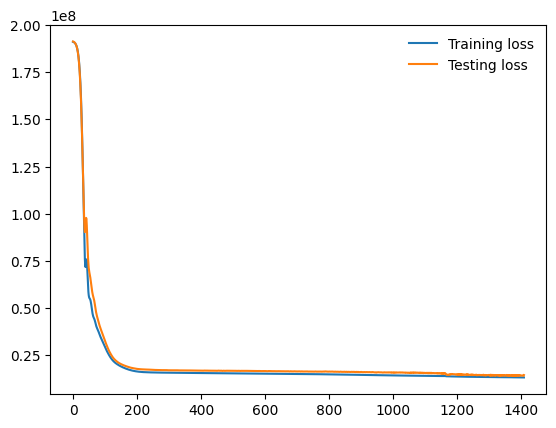

Эпоха 0 - train loss: 191233072.0, test loss: 191424224.0
Эпоха 100 - train loss: 30262110.0, test loss: 33437724.0
Эпоха 200 - train loss: 15810246.0, test loss: 17132140.0
Эпоха 300 - train loss: 15395402.0, test loss: 16569868.0
Эпоха 400 - train loss: 15187927.0, test loss: 16391913.0
Эпоха 500 - train loss: 14853916.0, test loss: 16174547.0
Эпоха 600 - train loss: 14398998.0, test loss: 15626793.0
Эпоха 700 - train loss: 13844662.0, test loss: 15108968.0
Эпоха 800 - train loss: 13446714.0, test loss: 14107860.0
Эпоха 900 - train loss: 13297925.0, test loss: 13976173.0
Эпоха 1000 - train loss: 13250591.0, test loss: 13431774.0
Early stopping at epoch 1063


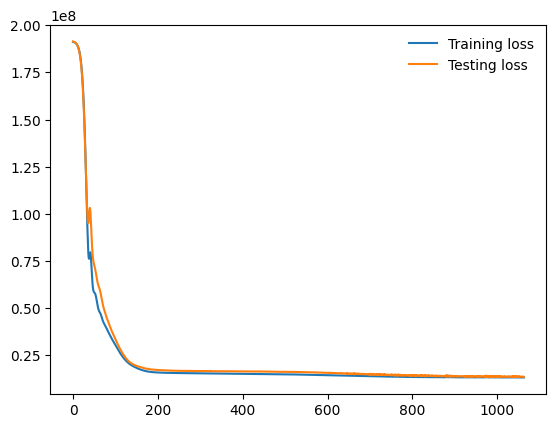

Эпоха 0 - train loss: 191244656.0, test loss: 191446288.0
Эпоха 100 - train loss: 30817528.0, test loss: 34769184.0
Эпоха 200 - train loss: 16397711.0, test loss: 17898752.0
Эпоха 300 - train loss: 15526680.0, test loss: 16825486.0
Эпоха 400 - train loss: 15320928.0, test loss: 16467314.0
Эпоха 500 - train loss: 15170814.0, test loss: 16332767.0
Эпоха 600 - train loss: 15001290.0, test loss: 16280152.0
Эпоха 700 - train loss: 14810217.0, test loss: 16118076.0
Early stopping at epoch 776


Эпоха 0 - train loss: 191237904.0, test loss: 191361520.0
Эпоха 100 - train loss: 29065750.0, test loss: 32204562.0
Эпоха 200 - train loss: 15758993.0, test loss: 17344090.0
Эпоха 300 - train loss: 15389457.0, test loss: 16642605.0
Эпоха 400 - train loss: 15219039.0, test loss: 16423938.0
Эпоха 500 - train loss: 15027142.0, test loss: 16203288.0
Эпоха 600 - train loss: 14730283.0, test loss: 15813760.0
Эпоха 700 - train loss: 14107964.0, test loss: 15033562.0
Эпоха 800 - train loss: 13173998.0, test loss: 14514526.0
Эпоха 900 - train loss: 12168973.0, test loss: 12918519.0
Эпоха 1000 - train loss: 11898115.0, test loss: 12514065.0
Эпоха 1100 - train loss: 11166648.0, test loss: 12179518.0
Эпоха 1200 - train loss: 10462090.0, test loss: 11726202.0
Early stopping at epoch 1262


Эпоха 0 - train loss: 191278624.0, test loss: 191450960.0
Эпоха 100 - train loss: 26320062.0, test loss: 28529160.0
Эпоха 200 - train loss: 15448881.0, test loss: 17120926.0
Эпоха 300 - train loss: 14681198.0, test loss: 16469998.0
Эпоха 400 - train loss: 12857771.0, test loss: 14264251.0
Эпоха 500 - train loss: 11249487.0, test loss: 12020217.0
Эпоха 600 - train loss: 10319052.0, test loss: 11883490.0
Early stopping at epoch 627


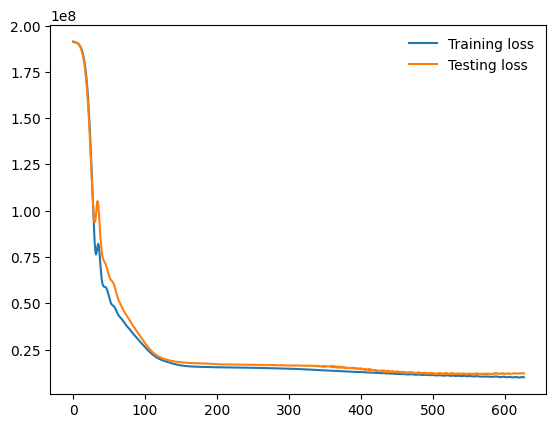

Эпоха 0 - train loss: 191314784.0, test loss: 191532720.0
Эпоха 100 - train loss: 34754564.0, test loss: 39610812.0
Эпоха 200 - train loss: 16746573.0, test loss: 17955458.0
Эпоха 300 - train loss: 15563950.0, test loss: 16786000.0
Эпоха 400 - train loss: 15402597.0, test loss: 16646900.0
Эпоха 500 - train loss: 15284506.0, test loss: 16592493.0
Эпоха 600 - train loss: 15173280.0, test loss: 16541170.0
Early stopping at epoch 690


Эпоха 0 - train loss: 191347248.0, test loss: 191495792.0
Эпоха 100 - train loss: 27965824.0, test loss: 30614050.0
Эпоха 200 - train loss: 15525438.0, test loss: 17103640.0
Эпоха 300 - train loss: 15060181.0, test loss: 16557313.0
Эпоха 400 - train loss: 14344694.0, test loss: 16573069.0
Early stopping at epoch 413


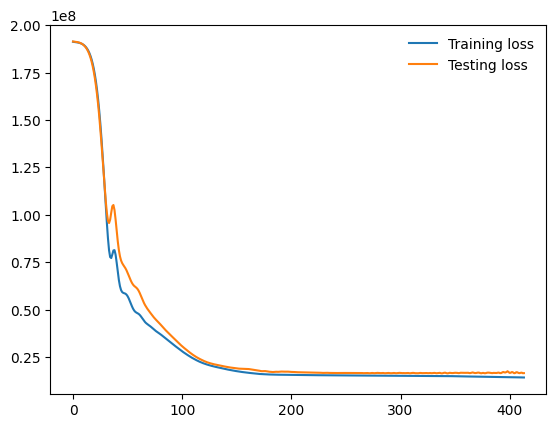

Эпоха 0 - train loss: 191157328.0, test loss: 191303296.0
Эпоха 100 - train loss: 24267358.0, test loss: 26331980.0
Эпоха 200 - train loss: 15703255.0, test loss: 17358740.0
Эпоха 300 - train loss: 15409451.0, test loss: 16926428.0
Эпоха 400 - train loss: 15290822.0, test loss: 16738752.0
Эпоха 500 - train loss: 15152268.0, test loss: 16833578.0
Early stopping at epoch 501


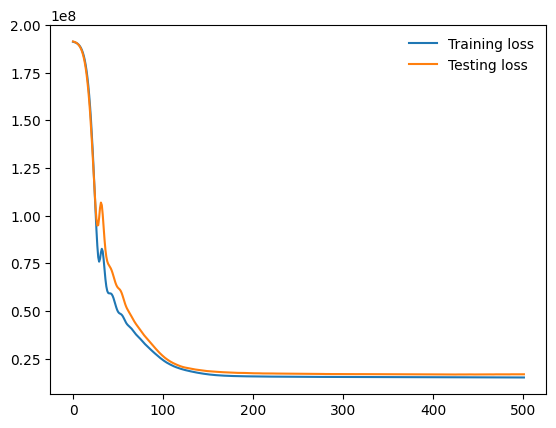

Эпоха 0 - train loss: 191270960.0, test loss: 191460992.0
Эпоха 100 - train loss: 30601836.0, test loss: 34451548.0
Эпоха 200 - train loss: 16055410.0, test loss: 18140994.0
Эпоха 300 - train loss: 15465373.0, test loss: 17710200.0
Эпоха 400 - train loss: 15317227.0, test loss: 17563402.0
Эпоха 500 - train loss: 15167208.0, test loss: 17342744.0
Эпоха 600 - train loss: 14961171.0, test loss: 16987890.0
Эпоха 700 - train loss: 14507902.0, test loss: 16439652.0
Эпоха 800 - train loss: 14056312.0, test loss: 16091887.0
Эпоха 900 - train loss: 13200457.0, test loss: 14105128.0
Эпоха 1000 - train loss: 12466522.0, test loss: 12447200.0
Эпоха 1100 - train loss: 12197894.0, test loss: 11793426.0
Эпоха 1200 - train loss: 12054975.0, test loss: 11721101.0
Эпоха 1300 - train loss: 11952788.0, test loss: 11698178.0
Эпоха 1400 - train loss: 11807145.0, test loss: 11613645.0
Early stopping at epoch 1445


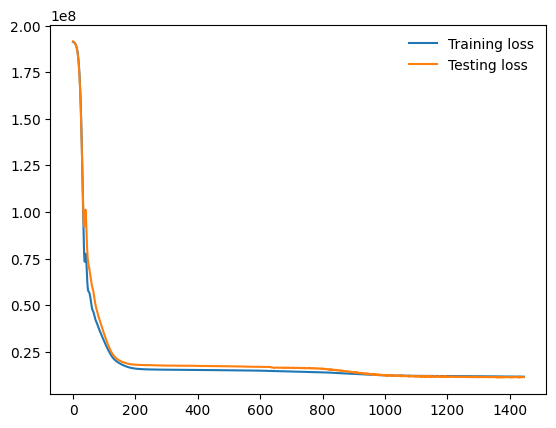

Эпоха 0 - train loss: 191231328.0, test loss: 191379872.0
Эпоха 100 - train loss: 31335058.0, test loss: 35487968.0
Эпоха 200 - train loss: 16365191.0, test loss: 18126716.0
Эпоха 300 - train loss: 15423812.0, test loss: 16966952.0
Эпоха 400 - train loss: 15105662.0, test loss: 16850222.0
Эпоха 500 - train loss: 14549745.0, test loss: 15626108.0
Эпоха 600 - train loss: 13623377.0, test loss: 13843239.0
Эпоха 700 - train loss: 13101834.0, test loss: 12744928.0
Эпоха 800 - train loss: 12355375.0, test loss: 11646133.0
Эпоха 900 - train loss: 11598191.0, test loss: 11511076.0
Эпоха 1000 - train loss: 10921849.0, test loss: 11144283.0
Early stopping at epoch 1083


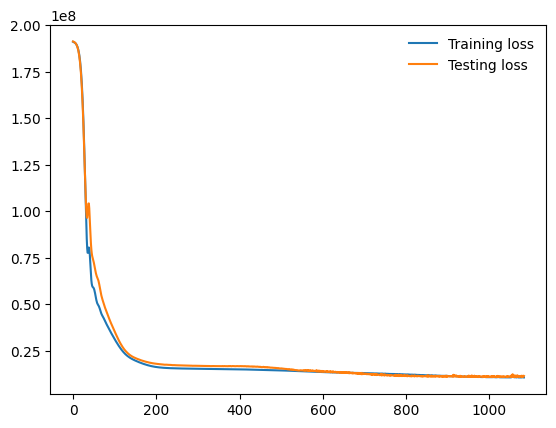

Эпоха 0 - train loss: 191315152.0, test loss: 191522416.0
Эпоха 100 - train loss: 27283640.0, test loss: 29509468.0
Эпоха 200 - train loss: 15847800.0, test loss: 17437480.0
Эпоха 300 - train loss: 15442027.0, test loss: 17105682.0
Early stopping at epoch 396


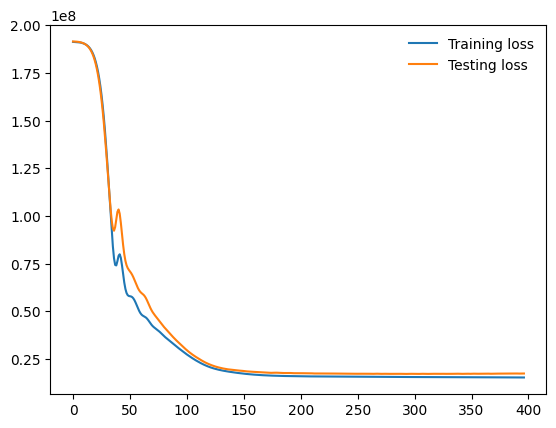

Эпоха 0 - train loss: 191313888.0, test loss: 191501520.0
Эпоха 100 - train loss: 33091258.0, test loss: 37578824.0
Эпоха 200 - train loss: 16455281.0, test loss: 18048926.0
Эпоха 300 - train loss: 15521722.0, test loss: 17048138.0
Эпоха 400 - train loss: 15376877.0, test loss: 16791474.0
Эпоха 500 - train loss: 15197882.0, test loss: 16774553.0
Early stopping at epoch 528


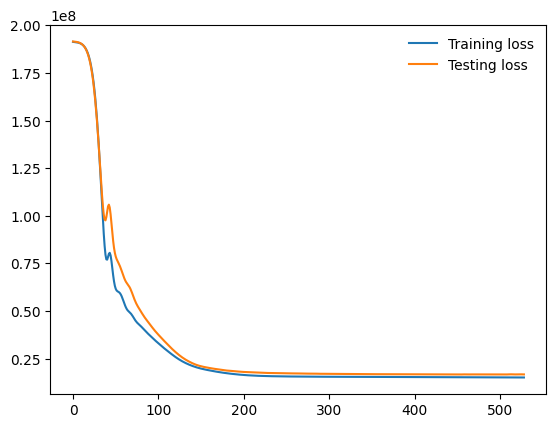

Эпоха 0 - train loss: 191342976.0, test loss: 191510400.0
Эпоха 100 - train loss: 28915720.0, test loss: 31621286.0
Эпоха 200 - train loss: 15645162.0, test loss: 17276944.0
Эпоха 300 - train loss: 15054699.0, test loss: 16858756.0
Эпоха 400 - train loss: 14088378.0, test loss: 16608340.0
Эпоха 500 - train loss: 12132961.0, test loss: 13679207.0
Эпоха 600 - train loss: 10403007.0, test loss: 13651204.0
Early stopping at epoch 608


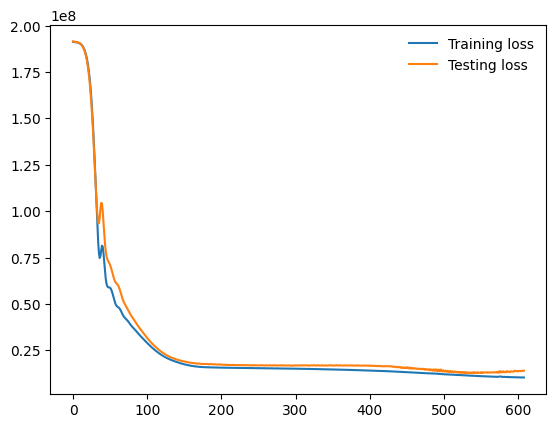

Эпоха 0 - train loss: 191214656.0, test loss: 191363008.0
Эпоха 100 - train loss: 25177586.0, test loss: 27853802.0
Эпоха 200 - train loss: 15666038.0, test loss: 17137888.0
Эпоха 300 - train loss: 15338029.0, test loss: 16587989.0
Эпоха 400 - train loss: 15017020.0, test loss: 16478994.0
Эпоха 500 - train loss: 14415804.0, test loss: 16255149.0
Эпоха 600 - train loss: 13573086.0, test loss: 15779470.0
Эпоха 700 - train loss: 12191342.0, test loss: 14411717.0
Эпоха 800 - train loss: 10348566.0, test loss: 14158414.0
Early stopping at epoch 836


Эпоха 0 - train loss: 191228176.0, test loss: 191348544.0
Эпоха 100 - train loss: 22559844.0, test loss: 24160770.0
Эпоха 200 - train loss: 15603026.0, test loss: 17139846.0
Эпоха 300 - train loss: 15339751.0, test loss: 16832482.0
Эпоха 400 - train loss: 15126165.0, test loss: 16732486.0
Эпоха 500 - train loss: 14731447.0, test loss: 16718732.0
Эпоха 600 - train loss: 14262127.0, test loss: 16425355.0
Эпоха 700 - train loss: 13857068.0, test loss: 15543593.0
Эпоха 800 - train loss: 13580236.0, test loss: 14795556.0
Эпоха 900 - train loss: 13384322.0, test loss: 14687399.0
Эпоха 1000 - train loss: 13150258.0, test loss: 14270648.0
Эпоха 1100 - train loss: 11900661.0, test loss: 12270585.0
Эпоха 1200 - train loss: 10702666.0, test loss: 11544213.0
Early stopping at epoch 1298


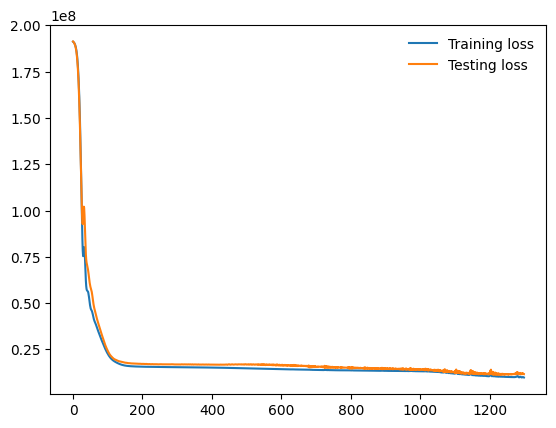

Эпоха 0 - train loss: 191243040.0, test loss: 191376256.0
Эпоха 100 - train loss: 23397282.0, test loss: 25481540.0
Эпоха 200 - train loss: 15710178.0, test loss: 17528956.0
Эпоха 300 - train loss: 15243871.0, test loss: 16782160.0
Эпоха 400 - train loss: 14740200.0, test loss: 16145999.0
Эпоха 500 - train loss: 13307866.0, test loss: 15053102.0
Эпоха 600 - train loss: 11893205.0, test loss: 13150983.0
Early stopping at epoch 691


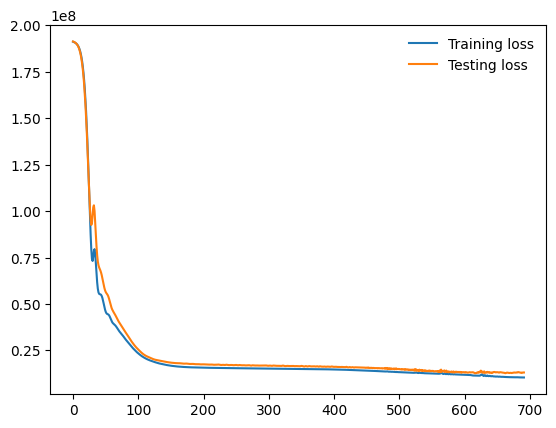

Эпоха 0 - train loss: 191281648.0, test loss: 191410208.0
Эпоха 100 - train loss: 21054278.0, test loss: 22645688.0
Эпоха 200 - train loss: 15680064.0, test loss: 16921264.0
Эпоха 300 - train loss: 15368021.0, test loss: 16612059.0
Эпоха 400 - train loss: 14710796.0, test loss: 16591245.0
Эпоха 500 - train loss: 13877428.0, test loss: 15381670.0
Эпоха 600 - train loss: 12735789.0, test loss: 14783729.0
Early stopping at epoch 620


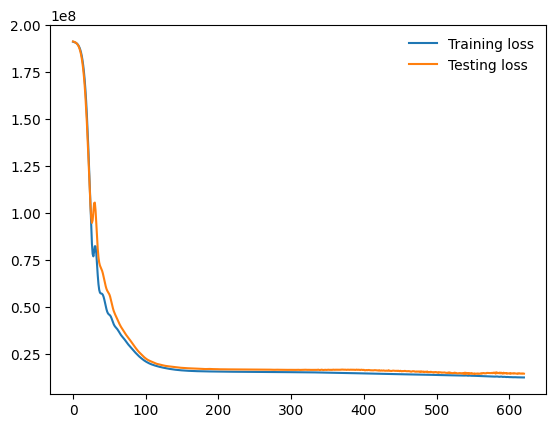

Эпоха 0 - train loss: 191267216.0, test loss: 191454912.0
Эпоха 100 - train loss: 31047218.0, test loss: 34768036.0
Эпоха 200 - train loss: 16275602.0, test loss: 17596778.0
Эпоха 300 - train loss: 15449789.0, test loss: 16690773.0
Эпоха 400 - train loss: 15272798.0, test loss: 16595694.0
Эпоха 500 - train loss: 15122935.0, test loss: 16556883.0
Early stopping at epoch 511


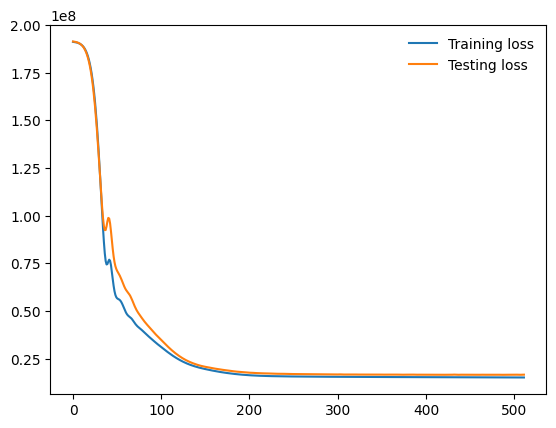

Эпоха 0 - train loss: 191266064.0, test loss: 191462688.0
Эпоха 100 - train loss: 27532404.0, test loss: 30417962.0
Эпоха 200 - train loss: 15960023.0, test loss: 17343354.0
Эпоха 300 - train loss: 15529701.0, test loss: 16904132.0
Early stopping at epoch 386


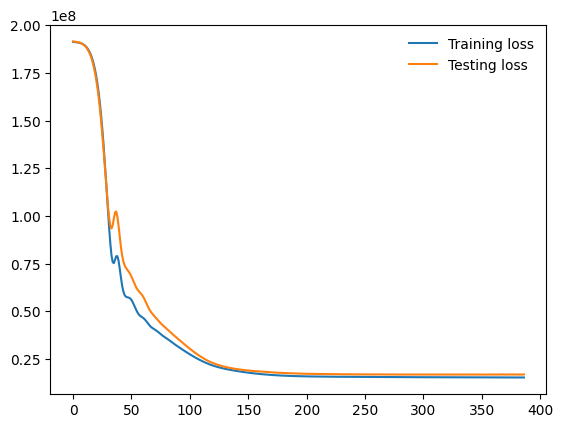

Эпоха 0 - train loss: 191271024.0, test loss: 191433872.0
Эпоха 100 - train loss: 23949100.0, test loss: 25361330.0
Эпоха 200 - train loss: 15580126.0, test loss: 17049276.0
Эпоха 300 - train loss: 15256305.0, test loss: 16589523.0
Эпоха 400 - train loss: 14918788.0, test loss: 16310955.0
Эпоха 500 - train loss: 14211149.0, test loss: 15726946.0
Эпоха 600 - train loss: 13454152.0, test loss: 15109922.0
Эпоха 700 - train loss: 12812807.0, test loss: 14524293.0
Эпоха 800 - train loss: 11877170.0, test loss: 14491419.0
Early stopping at epoch 812


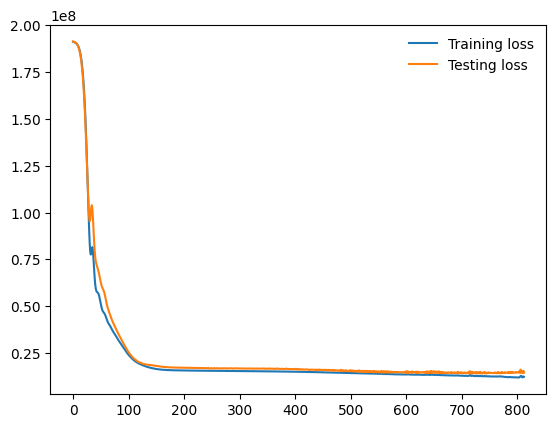

Эпоха 0 - train loss: 191273568.0, test loss: 191480688.0
Эпоха 100 - train loss: 27893876.0, test loss: 30996606.0
Эпоха 200 - train loss: 15751646.0, test loss: 17135960.0
Эпоха 300 - train loss: 15195789.0, test loss: 16482642.0
Эпоха 400 - train loss: 14532897.0, test loss: 16155691.0
Эпоха 500 - train loss: 13510033.0, test loss: 15370020.0
Эпоха 600 - train loss: 12057839.0, test loss: 14204283.0
Эпоха 700 - train loss: 10756968.0, test loss: 13597657.0
Early stopping at epoch 772


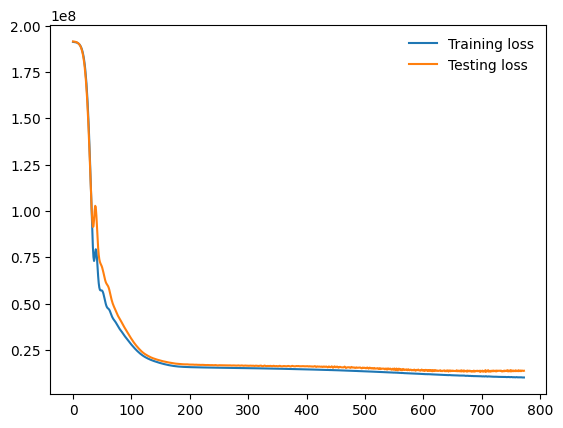

Эпоха 0 - train loss: 191274976.0, test loss: 191452256.0
Эпоха 100 - train loss: 24690146.0, test loss: 26728726.0
Эпоха 200 - train loss: 15817643.0, test loss: 17449924.0
Эпоха 300 - train loss: 15488056.0, test loss: 16916542.0
Эпоха 400 - train loss: 15352179.0, test loss: 16884126.0
Эпоха 500 - train loss: 15046478.0, test loss: 16984190.0
Эпоха 600 - train loss: 14432742.0, test loss: 16649330.0
Эпоха 700 - train loss: 13747851.0, test loss: 16312915.0
Эпоха 800 - train loss: 13062276.0, test loss: 15397650.0
Эпоха 900 - train loss: 12310459.0, test loss: 14678349.0
Эпоха 1000 - train loss: 11472506.0, test loss: 14240443.0
Early stopping at epoch 1006


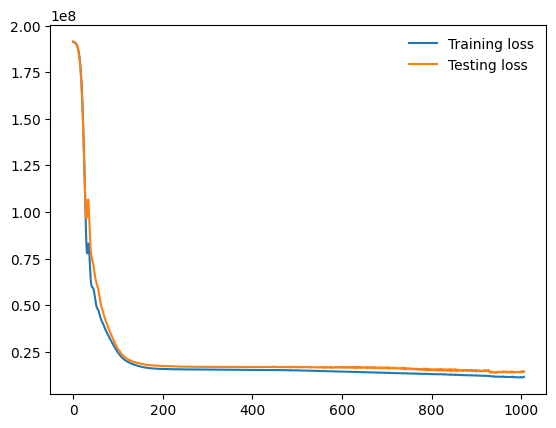

Эпоха 0 - train loss: 191334560.0, test loss: 191472928.0
Эпоха 100 - train loss: 19916722.0, test loss: 21136368.0
Эпоха 200 - train loss: 15396348.0, test loss: 17247206.0
Эпоха 300 - train loss: 14896147.0, test loss: 17196414.0
Эпоха 400 - train loss: 14119784.0, test loss: 16826416.0
Эпоха 500 - train loss: 12849621.0, test loss: 15403842.0
Эпоха 600 - train loss: 10997608.0, test loss: 13588849.0
Эпоха 700 - train loss: 9538688.0, test loss: 12708753.0
Early stopping at epoch 749


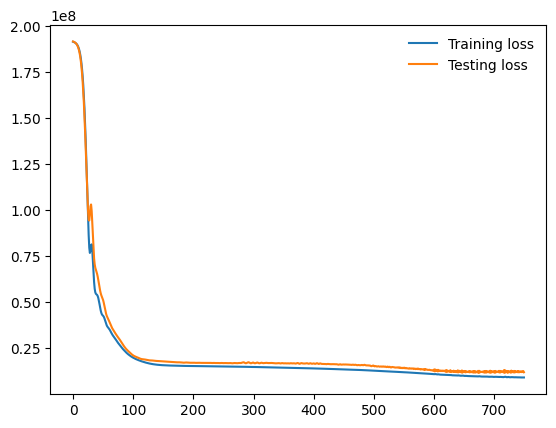

Эпоха 0 - train loss: 191220048.0, test loss: 191335136.0
Эпоха 100 - train loss: 23128684.0, test loss: 25346658.0
Эпоха 200 - train loss: 15579388.0, test loss: 17130428.0
Эпоха 300 - train loss: 15324278.0, test loss: 16856682.0
Эпоха 400 - train loss: 15097077.0, test loss: 16714837.0
Эпоха 500 - train loss: 14704127.0, test loss: 16268115.0
Эпоха 600 - train loss: 13808423.0, test loss: 15960975.0
Эпоха 700 - train loss: 12900279.0, test loss: 16132850.0
Эпоха 800 - train loss: 12075678.0, test loss: 15622679.0
Эпоха 900 - train loss: 11568716.0, test loss: 15039166.0
Эпоха 1000 - train loss: 11325278.0, test loss: 15819550.0
Эпоха 1100 - train loss: 10502850.0, test loss: 14501818.0
Эпоха 1200 - train loss: 10204894.0, test loss: 14151416.0
Эпоха 1300 - train loss: 10296661.0, test loss: 14512718.0
Эпоха 1400 - train loss: 9747534.0, test loss: 13517255.0
Эпоха 1500 - train loss: 9581090.0, test loss: 13376719.0
Эпоха 1600 - train loss: 9598719.0, test loss: 12960037.0
Эпоха 1700

Эпоха 0 - train loss: 191246336.0, test loss: 191426864.0
Эпоха 100 - train loss: 22381128.0, test loss: 24586626.0
Эпоха 200 - train loss: 15496531.0, test loss: 17610198.0
Эпоха 300 - train loss: 14947511.0, test loss: 16959648.0
Эпоха 400 - train loss: 14331771.0, test loss: 16635599.0
Эпоха 500 - train loss: 13309770.0, test loss: 15029643.0
Эпоха 600 - train loss: 11798129.0, test loss: 12887799.0
Early stopping at epoch 688


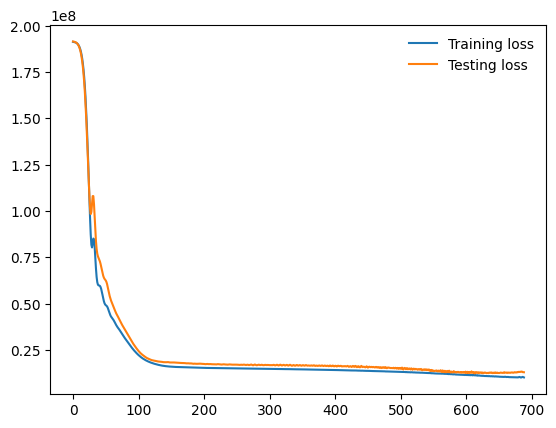

Эпоха 0 - train loss: 191381488.0, test loss: 191520128.0
Эпоха 100 - train loss: 23690980.0, test loss: 26186500.0
Эпоха 200 - train loss: 15413401.0, test loss: 17118636.0
Эпоха 300 - train loss: 14809268.0, test loss: 16755595.0
Эпоха 400 - train loss: 13773690.0, test loss: 15820436.0
Эпоха 500 - train loss: 12554022.0, test loss: 14363000.0
Эпоха 600 - train loss: 10591476.0, test loss: 12275661.0
Эпоха 700 - train loss: 9389704.0, test loss: 12438831.0
Early stopping at epoch 712


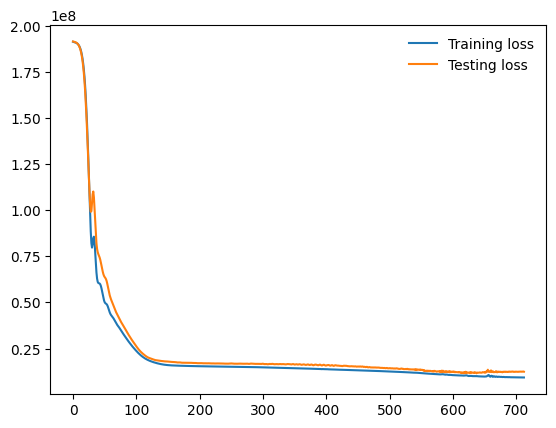

RMSE первичной модели: 3121.861083984375
Архитектура первичной модели: (20, 60, 60, 20)
CPU times: total: 10min 12s
Wall time: 5min 17s


In [23]:
%%time

neurons_per_layer = [20, 40, 60]
max_hidden_layers = 4

best_rmse = float('inf')
best_model_structure = None

layer_structures = list(itertools.product(neurons_per_layer, repeat=max_hidden_layers))

for layer_structure in layer_structures:
    model = StarTempPredictor(layer_structure)
    model.apply(init_weights)
    
    model, train_losses, test_losses = train_model(model, X_train, y_train, X_test, y_test)
    
    with torch.no_grad():
        model.eval()
        predictions = model(X_test)
        mse = F.mse_loss(predictions, y_test)
        rmse = torch.sqrt(mse).item()

        if rmse < best_rmse:
            best_rmse = rmse
            best_model_structure = layer_structure
            primary_model = model

    # Plot losses
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Testing loss')
    plt.legend(frameon=False)
    plt.show()

print('RMSE первичной модели:', best_rmse)
print('Архитектура первичной модели:', best_model_structure)

In [ ]:
хуй

### Строим график "Факт-Прогноз".

In [24]:
predictions = primary_model(X_test)
mse = F.mse_loss(predictions, y_test)
rmse = torch.sqrt(mse).item()

# Перевод модели в режим тестирования
model.eval()

# Получение прогнозов модели на тестовом наборе данных
predictions = model(X_test)

# Номера звезд для оси X
stars = np.arange(len(y_test))

# Фактические и прогнозируемые значения
y_test_np = y_test.detach().numpy().flatten()
predictions_np = predictions.detach().numpy().flatten()

# Размеры фигуры
plt.figure(figsize=(20, 10))

# Построение графика для фактических значений с оранжевыми столбцами
plt.bar(stars, y_test_np, width=0.6, label='Факт', color='orange', alpha=0.5)

# Построение графика для прогнозируемых значений с красными столбцами, накладывающимися по центру столбцов фактических данных
plt.bar(stars, predictions_np, width=0.3, label='Прогноз', color='red', alpha=0.7)

plt.title('Прогнозирование температуры звезды', fontsize=20)
plt.xlabel('Номер звезды в таблице данных', fontsize=20)
plt.ylabel('Температура звезды (Кельвины)', fontsize=20)
plt.legend(fontsize=15)

# Увеличение размера шрифта значений по осям
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(True)
plt.show()


### Вывод:

- Модель довольно дает приемлемые (за редким исключением) по точности предсказания относительно объектов, фактическая температура которых не превышает 10000 Кельвинов.
- Вместе с тем, точность предсказаний модели существенно снижается в отношении объектов, фактическая температура которых превышает 10000 Кельвинов.

## Улучшение нейронной сети

### Воссоздаем нейросеть с архитектурой, подобранной на предыдущем этапе.¶

In [25]:
class Net(nn.Module):
    def __init__(self, dropout):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(25, 20)
        self.fc2 = nn.Linear(20, 60)
        self.fc3 = nn.Linear(60, 60)
        self.fc4 = nn.Linear(60, 20)
        self.fc5 = nn.Linear(20, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x.squeeze()  


### Создаем решение с перебором параметров нейронной сети.¶

Эпоха 0 - train loss: 191247632.0, test loss: 191419536.0
Эпоха 100 - train loss: 32816474.0, test loss: 30547440.0
Эпоха 200 - train loss: 20592960.0, test loss: 18796110.0
Early stopping at epoch 280


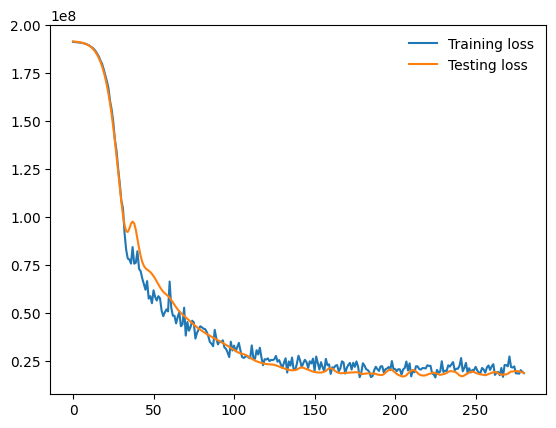

Эпоха 0 - train loss: 191183872.0, test loss: 191349456.0
Эпоха 100 - train loss: 29306494.0, test loss: 31972176.0
Эпоха 200 - train loss: 22496120.0, test loss: 20268134.0
Эпоха 300 - train loss: 18284186.0, test loss: 19205030.0
Early stopping at epoch 349


Эпоха 0 - train loss: 191174704.0, test loss: 191303472.0
Эпоха 100 - train loss: 28072332.0, test loss: 30088590.0
Эпоха 200 - train loss: 26760170.0, test loss: 18208512.0
Эпоха 300 - train loss: 16765737.0, test loss: 16889276.0
Early stopping at epoch 364


Эпоха 0 - train loss: 191244112.0, test loss: 191391216.0
Эпоха 100 - train loss: 33807784.0, test loss: 30672116.0
Эпоха 200 - train loss: 30222654.0, test loss: 23070338.0
Эпоха 300 - train loss: 31671736.0, test loss: 16848182.0
Early stopping at epoch 374


Эпоха 0 - train loss: 191219936.0, test loss: 191429936.0
Эпоха 100 - train loss: 38363064.0, test loss: 38675584.0
Эпоха 200 - train loss: 35795896.0, test loss: 21092816.0
Эпоха 300 - train loss: 26904058.0, test loss: 19827354.0
Early stopping at epoch 390


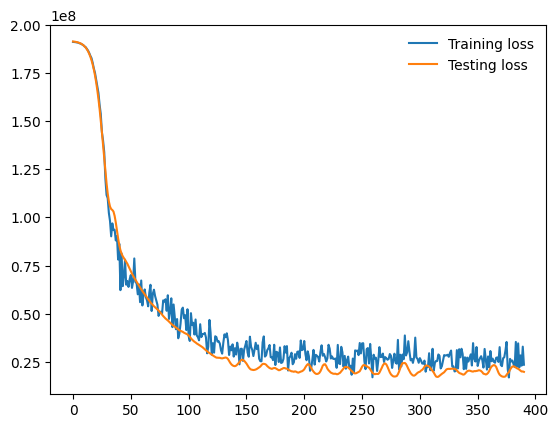

Эпоха 0 - train loss: 191194400.0, test loss: 191335392.0
Эпоха 100 - train loss: 46612948.0, test loss: 31331852.0
Эпоха 200 - train loss: 35503472.0, test loss: 24703486.0
Early stopping at epoch 283


Эпоха 0 - train loss: 191292032.0, test loss: 191500400.0
Эпоха 100 - train loss: 51266488.0, test loss: 39066404.0
Эпоха 200 - train loss: 46453932.0, test loss: 25572114.0
Early stopping at epoch 231


Эпоха 0 - train loss: 191424976.0, test loss: 191536912.0
Эпоха 100 - train loss: 63233004.0, test loss: 48507284.0
Эпоха 200 - train loss: 80440768.0, test loss: 32389532.0
Эпоха 300 - train loss: 42454544.0, test loss: 25632222.0
Early stopping at epoch 301


Эпоха 0 - train loss: 191391456.0, test loss: 191541856.0
Эпоха 100 - train loss: 67354024.0, test loss: 43688624.0
Эпоха 200 - train loss: 60272524.0, test loss: 33657080.0
Early stopping at epoch 287


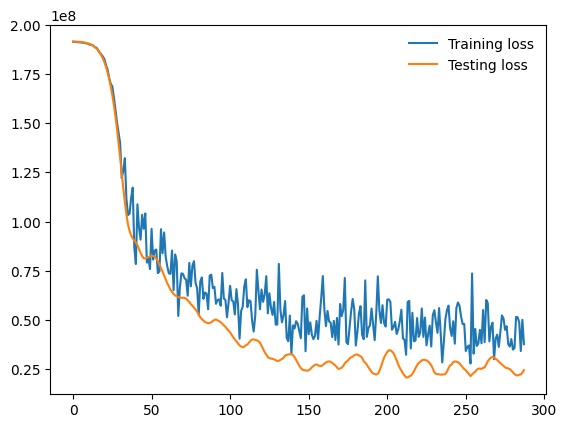

RMSE финальной модели: 4026.366455078125
Настройки финальной модели (Dropout, Batch size): (0.1, 64)
CPU times: total: 45.3 s
Wall time: 19.3 s


In [26]:
%%time

dropout_values = [0.1, 0.25, 0.5]
batch_sizes = [16, 32, 64]

best_rmse = float('inf')
best_model_structure = None

for dropout in dropout_values:
    for batch_size in batch_sizes:
        model = Net(dropout)
        model.apply(init_weights)
        
        loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size)
        X_train_batches, y_train_batches = zip(*list(loader))
        X_train_batches, y_train_batches = torch.cat(X_train_batches), torch.cat(y_train_batches)

        model, train_losses, test_losses = train_model(model, X_train_batches, y_train_batches, X_test, y_test)
        
        with torch.no_grad():
            model.eval()
            predictions = model(X_test)
            mse = F.mse_loss(predictions, y_test)
            rmse = torch.sqrt(mse).item()

            if rmse < best_rmse:
                best_rmse = rmse
                best_model_structure = (dropout, batch_size)
                final_model = model

        # Plot losses
        plt.plot(train_losses, label='Training loss')
        plt.plot(test_losses, label='Testing loss')
        plt.legend(frameon=False)
        plt.show()

print('RMSE финальной модели:', best_rmse)
print('Настройки финальной модели (Dropout, Batch size):', best_model_structure)

### Строим график "Факт-Прогноз".

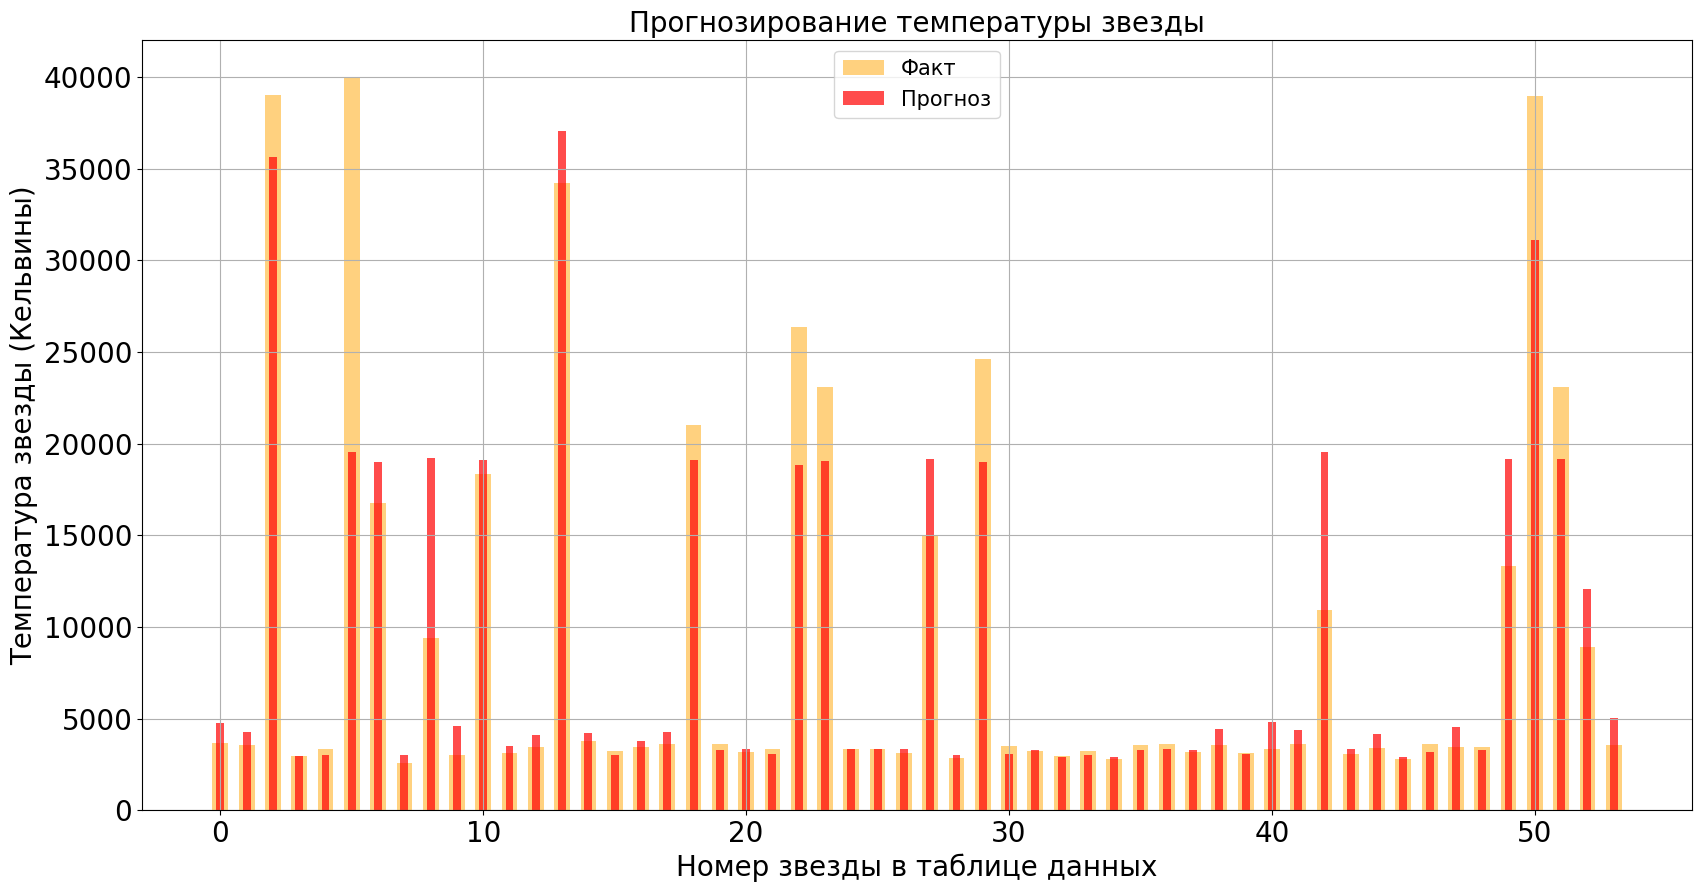

In [27]:
# Перевод модели в режим тестирования
final_model.eval()

# Получение прогнозов модели на тестовом наборе данных
predictions = final_model(X_test)

# Номера звезд для оси X
stars = np.arange(len(y_test))

# Фактические и прогнозируемые значения
y_test_np = y_test.detach().numpy().flatten()
predictions_np = predictions.detach().numpy().flatten()

# Размеры фигуры
plt.figure(figsize=(20, 10))

# Построение графика для фактических значений с оранжевыми столбцами
plt.bar(stars, y_test_np, width=0.6, label='Факт', color='orange', alpha=0.5)

# Построение графика для прогнозируемых значений с красными столбцами, накладывающимися по центру столбцов фактических данных
plt.bar(stars, predictions_np, width=0.3, label='Прогноз', color='red', alpha=0.7)

plt.title('Прогнозирование температуры звезды', fontsize=20)
plt.xlabel('Номер звезды в таблице данных', fontsize=20)
plt.ylabel('Температура звезды (Кельвины)', fontsize=20)
plt.legend(fontsize=15)

# Увеличение размера шрифта значений по осям
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(True)
plt.show()

### Вывод:

Регуляризация при помощи dropout и batches в данной случае не улучшила, а, наоборот, ухудшила качество модели.

## Выводы

- Нейросеть, подобранная изначально, позволила добиться метрики RMSE ≈ 3100 при целевой метрике 4500. В подборе оптимальных параметров нейросети очень сильно помогло внедрение алгоритма EarlyStopping и постепенное снижение learning rate.
- Добавление к выбранной нейросети параметров dropout и batches не привело к улучшению качества, а, наоборот, снизило целевую метрику RMSE до ≈ 4000, что, тем не менее, позволило достичь цели проекта.
- Таким образом, регуляризация не всегда приводит к улучшению качества нейросети.